In [1]:
import numpy as np
import os
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import scipy.stats
from functools import partial
from bayesian_changepoint_detection.bayesian_models import offline_changepoint_detection
import bayesian_changepoint_detection.offline_likelihoods as offline_ll
from bayesian_changepoint_detection.priors import const_prior
from scipy.signal import argrelextrema

Use scipy logsumexp().


## Collect the 2021 State Contact Index into one file

In [9]:
directory = './State_Mobility_Index/'
dates=set()
states=set()

CMI = {}
CMI_YOY = {}
first = True

for filename in os.listdir(directory):
    if filename.endswith(".csv") and "2021" in filename:
        str_date=filename.split('.')[0].split('_')[1].strip()
        dates.add(str_date)
        with open(directory+filename,'r') as fr:
            line=fr.readline()#header
            while True:
                line=fr.readline()
                if len(line)==0:
                    break
                data=line.split(',')
                state=data[0]
                if state=="District of Col..":
                    state="District of Columbia"
                if state=="New Hampshi..":
                    state="New Hampshire"
                if first:
                    states.add(state)
                CMI[(state,str_date)]=float(data[1])
                CMI_YOY[(state,str_date)]=float(data[2].strip().replace("%",''))
            first = False
        
print(len(dates))
print(len(states))
print(len(CMI),CMI)
print(len(CMI_YOY),CMI_YOY)

365
49
17885 {('Mississippi', '2021-04-20'): 4.15, ('Alabama', '2021-04-20'): 4.14, ('Tennessee', '2021-04-20'): 4.11, ('South Carolina', '2021-04-20'): 4.1, ('Georgia', '2021-04-20'): 4.1, ('Arkansas', '2021-04-20'): 4.09, ('North Carolina', '2021-04-20'): 4.08, ('Oklahoma', '2021-04-20'): 4.08, ('Kentucky', '2021-04-20'): 4.08, ('Missouri', '2021-04-20'): 4.06, ('Louisiana', '2021-04-20'): 4.06, ('Maine', '2021-04-20'): 4.04, ('Indiana', '2021-04-20'): 4.04, ('West Virginia', '2021-04-20'): 4.04, ('Iowa', '2021-04-20'): 4.02, ('Texas', '2021-04-20'): 4.02, ('Ohio', '2021-04-20'): 4.02, ('Delaware', '2021-04-20'): 4.01, ('Wisconsin', '2021-04-20'): 3.99, ('Minnesota', '2021-04-20'): 3.99, ('Kansas', '2021-04-20'): 3.97, ('Virginia', '2021-04-20'): 3.97, ('New Hampshire', '2021-04-20'): 3.97, ('Maryland', '2021-04-20'): 3.97, ('Michigan', '2021-04-20'): 3.97, ('Florida', '2021-04-20'): 3.96, ('Arizona', '2021-04-20'): 3.95, ('Nebraska', '2021-04-20'): 3.95, ('Vermont', '2021-04-20'): 3

In [10]:
fw=open('2021data/2021_state_CMI.txt','w')
fw2=open('2021data/2021_state_CMI_YOY.txt','w')
dates=sorted(dates, key=lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
print(dates)
print(states)
fw.write('date,'+','.join(states))
fw2.write('date,'+','.join(states))
for date in dates:
    fw.write('\n'+date)
    fw2.write('\n'+date)
    for state in states:
        fw.write(','+str(CMI[(state,date)]))
        fw2.write(','+str(CMI_YOY[(state,date)]))
        
fw.close()
fw2.close()

['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08', '2021-01-09', '2021-01-10', '2021-01-11', '2021-01-12', '2021-01-13', '2021-01-14', '2021-01-15', '2021-01-16', '2021-01-17', '2021-01-18', '2021-01-19', '2021-01-20', '2021-01-21', '2021-01-22', '2021-01-23', '2021-01-24', '2021-01-25', '2021-01-26', '2021-01-27', '2021-01-28', '2021-01-29', '2021-01-30', '2021-01-31', '2021-02-01', '2021-02-02', '2021-02-03', '2021-02-04', '2021-02-05', '2021-02-06', '2021-02-07', '2021-02-08', '2021-02-09', '2021-02-10', '2021-02-11', '2021-02-12', '2021-02-13', '2021-02-14', '2021-02-15', '2021-02-16', '2021-02-17', '2021-02-18', '2021-02-19', '2021-02-20', '2021-02-21', '2021-02-22', '2021-02-23', '2021-02-24', '2021-02-25', '2021-02-26', '2021-02-27', '2021-02-28', '2021-03-01', '2021-03-02', '2021-03-03', '2021-03-04', '2021-03-05', '2021-03-06', '2021-03-07', '2021-03-08', '2021-03-09', '2021-03-10', '2021-03-11', '2021-03-12', '2021

## Visualize the contact index

(365, 1)


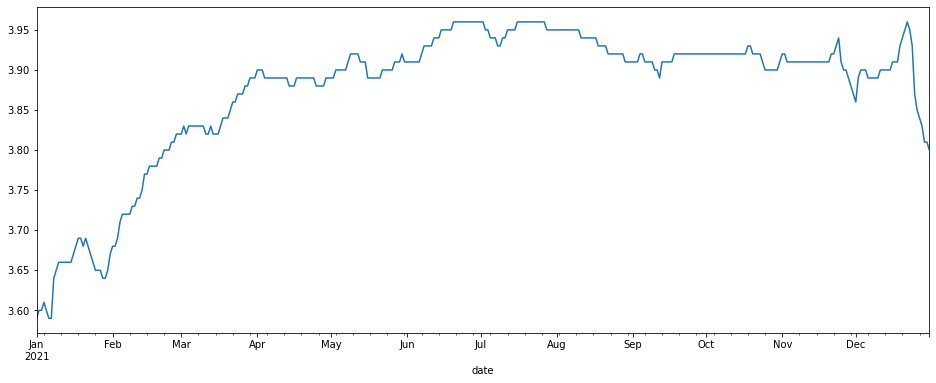

In [3]:
## Cuebiq Contact Index data

path="./2021data/"
df=pd.read_csv(path+'2021_state_CMI.txt',dtype=object,sep = ",")
df = df[["date","California"]]
df.set_index("date",inplace = True)

distance_df = df.copy()
distance_df.index = pd.to_datetime(df.index) # convert to datetime
distance_df.columns=['Distance']
distance_df['Distance'] = pd.to_numeric(distance_df['Distance'])
distance_df=distance_df.sort_index(ascending=True) # select ranges of dates, sort the rows by date first
# start = distance_df.index.searchsorted(dt.datetime(2021, 9, 10))
#end = distance_df.index.searchsorted(dt.datetime(2021, 11, 2))
# distance_df = distance_df.iloc[start:]
print(distance_df.shape)
distance_df['Distance'].plot(figsize = (16,6))
plt.show()


## Visualize the NYT data/hospital data

In [11]:
hospital_data = pd.read_csv('2021data/nyt-us-states.csv')
print(hospital_data.head())

         date       state  fips  cases  deaths
0  2020-01-21  Washington    53      1       0
1  2020-01-22  Washington    53      1       0
2  2020-01-23  Washington    53      1       0
3  2020-01-24    Illinois    17      1       0
4  2020-01-24  Washington    53      1       0


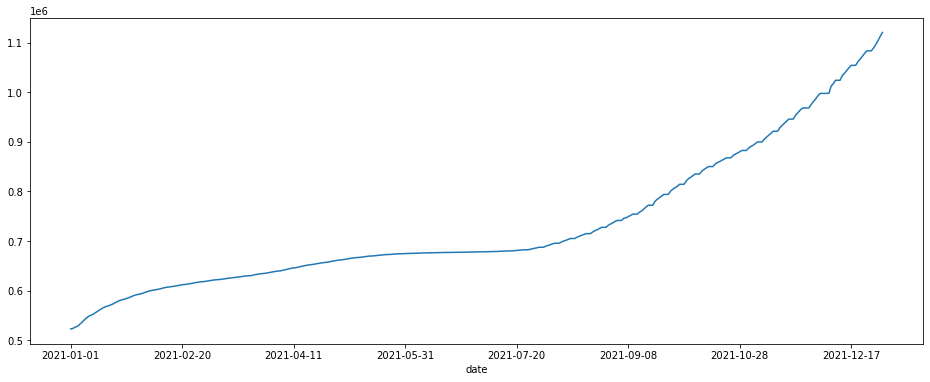

In [12]:
df = hospital_data[hospital_data['state'] == 'Wisconsin']
start_date = '2021-01-01'
end_date = '2021-12-31'
mask = (df['date'] >= start_date) & (df['date'] <= end_date)
NYT_hospital_data = df.loc[mask]

NYT_hospital_data.set_index('date',inplace=True)
NYT_hospital_data.sort_index(ascending=True,inplace = True) # select ranges of dates, sort the rows by date first
NYT_hospital_data['cases'].plot(figsize = (16,6))
plt.show()

In [13]:
NYT_hospital_data['cases']

date
2021-01-01     522523
2021-01-02     523652
2021-01-03     526245
2021-01-04     527871
2021-01-05     531890
               ...   
2021-12-27    1089123
2021-12-28    1096118
2021-12-29    1103932
2021-12-30    1112659
2021-12-31    1120669
Name: cases, Length: 365, dtype: int64

In [14]:
distance_df["Distance"]

date
2021-01-01    3.59
2021-01-02    3.60
2021-01-03    3.60
2021-01-04    3.61
2021-01-05    3.60
              ... 
2021-12-27    3.84
2021-12-28    3.83
2021-12-29    3.81
2021-12-30    3.81
2021-12-31    3.80
Name: Distance, Length: 365, dtype: float64

In [17]:
prev = hospital_data[(hospital_data['state'] == 'California')&(hospital_data['date'] == '2021-12-31')]["cases"].iloc[0]
prev

5515613

## Look at Daily cases

(365, 4)
date
2021-01-01    1000
2021-01-02    1129
2021-01-03    2593
2021-01-04    1626
2021-01-05    4019
              ... 
2021-12-27    5552
2021-12-28    6995
2021-12-29    7814
2021-12-30    8727
2021-12-31    8010
Length: 365, dtype: int64


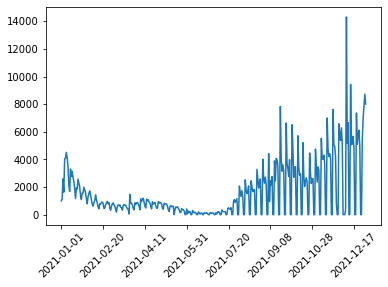

In [21]:
print(NYT_hospital_data.shape)


y=NYT_hospital_data['cases']
daily_hospital_data = [None] * len(y)
daily_hospital_data[0] = 1000
for i in range(1,len(y)):
    daily_hospital_data[i] = y[i] - y[i-1]

daily_hospital_data=pd.Series(daily_hospital_data)
daily_hospital_data.index =NYT_hospital_data.index
print(daily_hospital_data)
fig,ax = plt.subplots()
ax.plot(daily_hospital_data)
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
plt.xticks(rotation = 45)
plt.show()


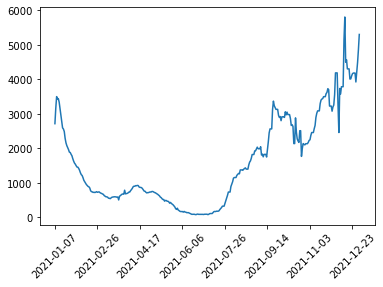

In [23]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

avg_daily_hospital_data = moving_average(daily_hospital_data,7)
avg_daily_hospital_data=pd.Series(avg_daily_hospital_data)
avg_daily_hospital_data.index =NYT_hospital_data.index[6:]
fig,ax = plt.subplots()
ax.plot(avg_daily_hospital_data)
ax.xaxis.set_major_locator(ticker.MultipleLocator(50))
plt.xticks(rotation = 45)
plt.show()

## Correlation between CMI and Cases

In [24]:
## Correlation
x = np.array(distance_df['Distance'])
x = x.astype(float)
y = np.array(NYT_hospital_data['cases'])
print(x,y)
print("length of CMI",len(x),"len of cases",len(y))
daily = np.array(daily_hospital_data)
print(daily)
print("length of daily",len(daily))

r, p = scipy.stats.pearsonr(x, y)
print(r,p)
r, p = scipy.stats.pearsonr(x, daily)
print(r,p)

r, p = scipy.stats.spearmanr(x, y)
print(r,p)
r, p = scipy.stats.spearmanr(x, daily)
print(r,p)

[3.59 3.6  3.6  3.61 3.6  3.59 3.59 3.64 3.65 3.66 3.66 3.66 3.66 3.66
 3.66 3.67 3.68 3.69 3.69 3.68 3.69 3.68 3.67 3.66 3.65 3.65 3.65 3.64
 3.64 3.65 3.67 3.68 3.68 3.69 3.71 3.72 3.72 3.72 3.72 3.73 3.73 3.74
 3.74 3.75 3.77 3.77 3.78 3.78 3.78 3.78 3.79 3.79 3.8  3.8  3.8  3.81
 3.81 3.82 3.82 3.82 3.83 3.82 3.83 3.83 3.83 3.83 3.83 3.83 3.83 3.82
 3.82 3.83 3.82 3.82 3.82 3.83 3.84 3.84 3.84 3.85 3.86 3.86 3.87 3.87
 3.87 3.88 3.88 3.89 3.89 3.89 3.9  3.9  3.9  3.89 3.89 3.89 3.89 3.89
 3.89 3.89 3.89 3.89 3.89 3.88 3.88 3.88 3.89 3.89 3.89 3.89 3.89 3.89
 3.89 3.89 3.88 3.88 3.88 3.88 3.89 3.89 3.89 3.89 3.9  3.9  3.9  3.9
 3.9  3.91 3.92 3.92 3.92 3.92 3.91 3.91 3.91 3.89 3.89 3.89 3.89 3.89
 3.89 3.9  3.9  3.9  3.9  3.9  3.91 3.91 3.91 3.92 3.91 3.91 3.91 3.91
 3.91 3.91 3.91 3.92 3.93 3.93 3.93 3.93 3.94 3.94 3.94 3.95 3.95 3.95
 3.95 3.95 3.96 3.96 3.96 3.96 3.96 3.96 3.96 3.96 3.96 3.96 3.96 3.96
 3.96 3.95 3.95 3.94 3.94 3.94 3.93 3.93 3.94 3.94 3.95 3.95 3.95 3.95
 3.96 3

In [25]:
avg_daily = np.array(avg_daily_hospital_data)
x_moving_average = moving_average(x,7)
print("len of avg_daily",len(avg_daily))
print("len of CMI avg",len(x_moving_average))
print(avg_daily)
print(x_moving_average)
r, p = scipy.stats.pearsonr(x_moving_average, avg_daily)
print(r,p)
r, p = scipy.stats.spearmanr(x_moving_average, avg_daily)
print(r,p)

len of avg_daily 359
len of CMI avg 359
[2712.14285714 3156.42857143 3497.42857143 3430.71428571 3438.71428571
 3337.         3145.85714286 2950.28571429 2749.71428571 2591.57142857
 2558.         2484.71428571 2288.42857143 2157.         2075.42857143
 2017.85714286 1961.14285714 1887.28571429 1877.42857143 1824.71428571
 1783.         1698.85714286 1627.57142857 1570.57142857 1537.57142857
 1492.         1453.71428571 1450.85714286 1413.57142857 1359.71428571
 1288.42857143 1234.57142857 1210.         1148.42857143 1071.57142857
 1029.71428571  983.28571429  947.85714286  918.71428571  892.57142857
  880.57142857  847.85714286  767.57142857  741.28571429  734.
  718.14285714  724.85714286  715.28571429  725.57142857  739.57142857
  722.14285714  730.          734.28571429  712.42857143  697.57142857
  688.28571429  672.71428571  662.          625.42857143  610.57142857
  591.71428571  590.57142857  580.14285714  551.28571429  549.28571429
  538.28571429  557.42857143  578.          5

## Visualize all states

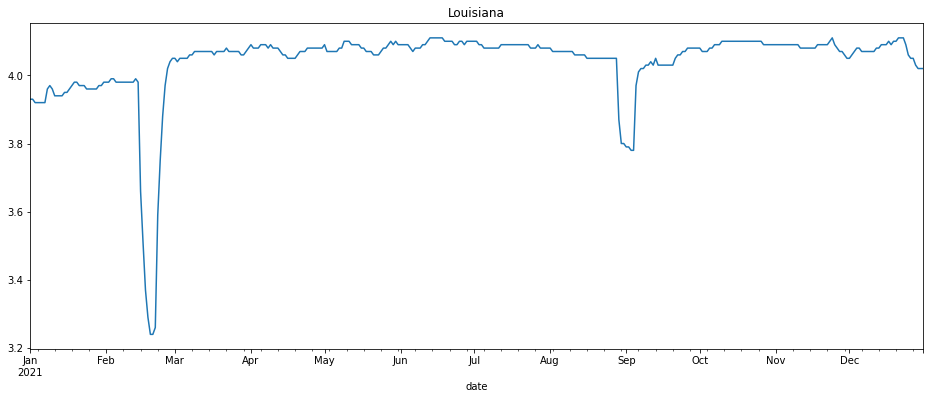

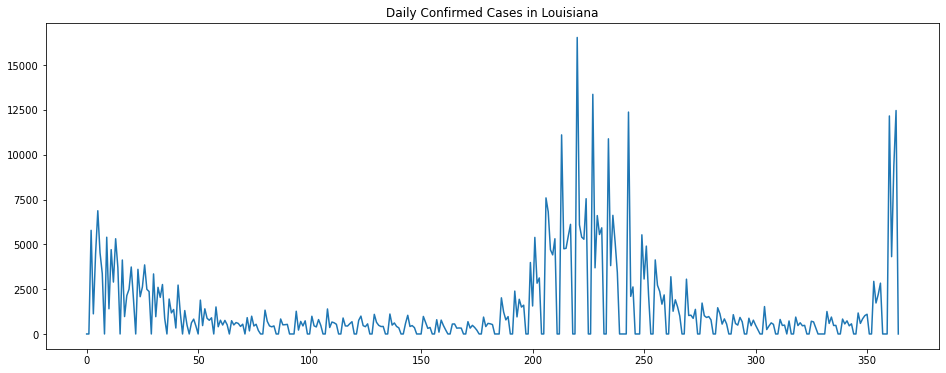

Louisiana -0.07687718987809929 0.1426840096311083
Louisiana -0.24147806260861854 3.058509346118613e-06
pearson from average Louisiana -0.1284677797731474 0.01486181502194719
spearman from average Louisiana -0.553281777791486 3.5386209437383666e-30


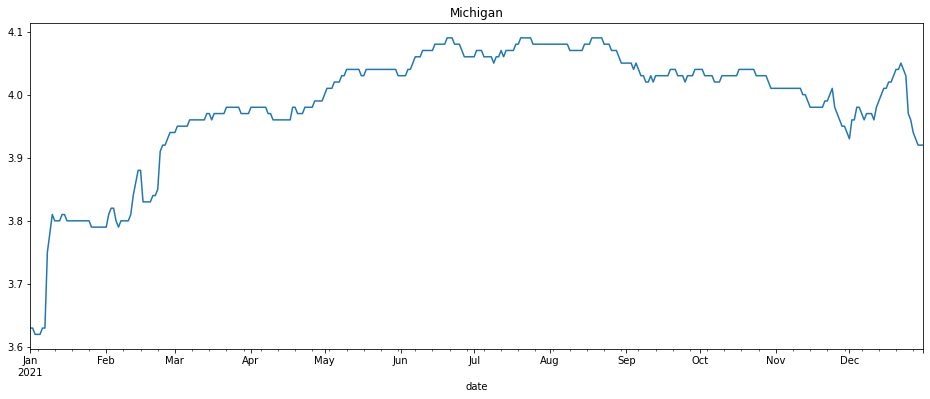

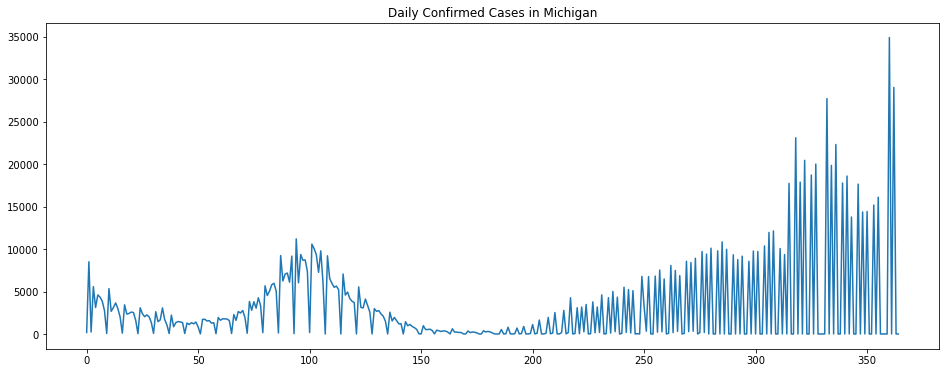

Michigan -0.08015369040755058 0.12637807860522707
Michigan -0.25339341707139174 9.354818432686134e-07
pearson from average Michigan -0.14932049603916653 0.004578774414006458
spearman from average Michigan -0.46773706572726514 6.476313037988107e-21


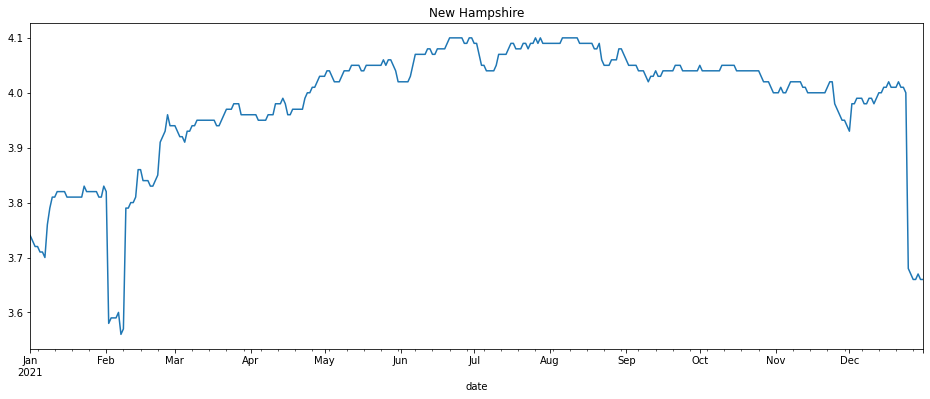

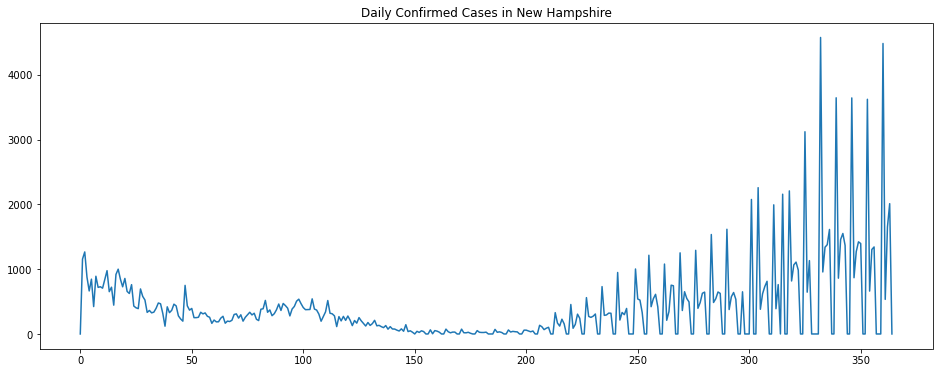

New Hampshire -0.23302957329696575 6.832570185646258e-06
New Hampshire -0.4479004165294916 2.0707212338694563e-19
pearson from average New Hampshire -0.3800388261768799 8.835677047982589e-14
spearman from average New Hampshire -0.6002568339610106 1.6241252311401696e-36


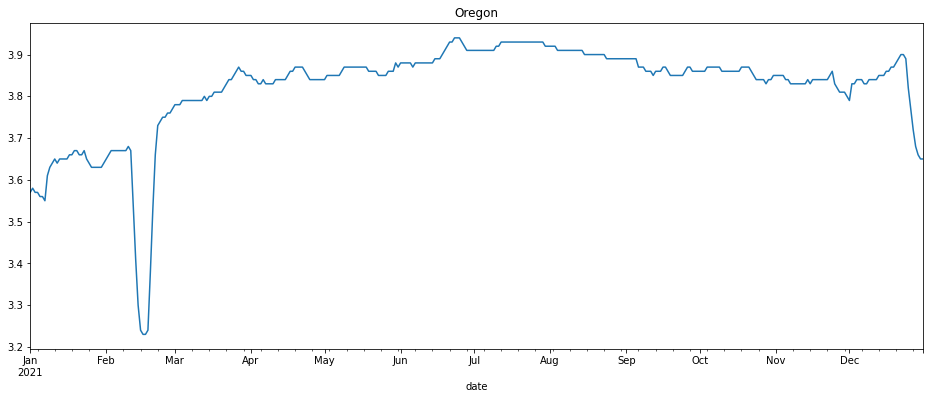

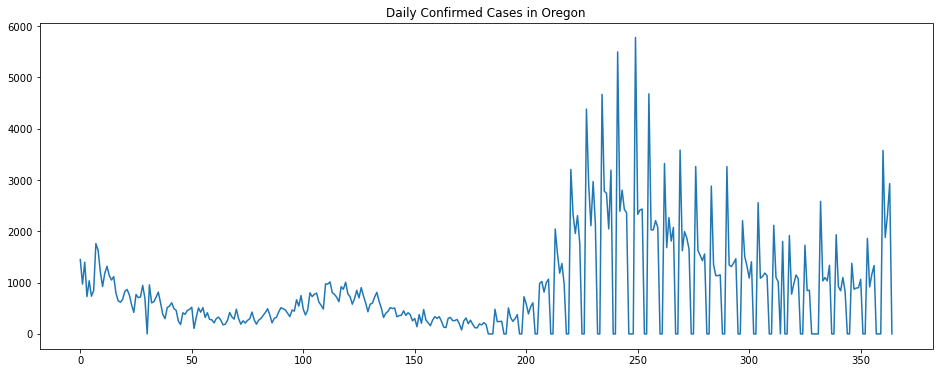

Oregon 0.054341257778597746 0.30048568307678397
Oregon -0.07215621743917355 0.16894309827850695
pearson from average Oregon 0.13540305525515817 0.010216532231144618
spearman from average Oregon 0.005351087651675263 0.9195220651730712


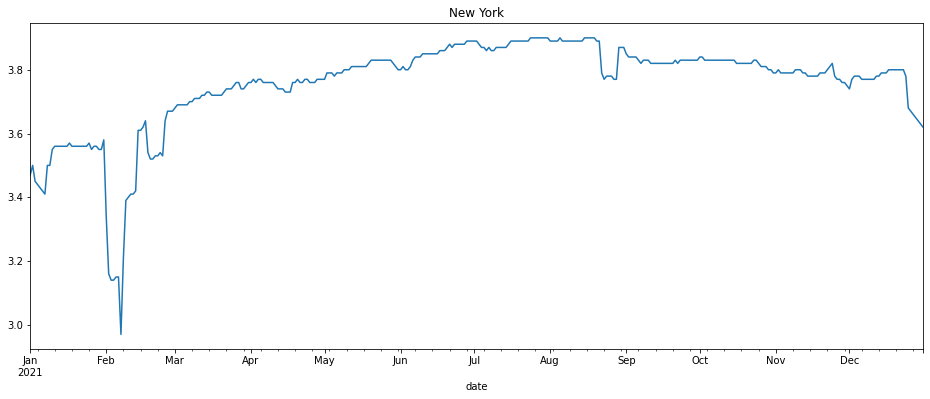

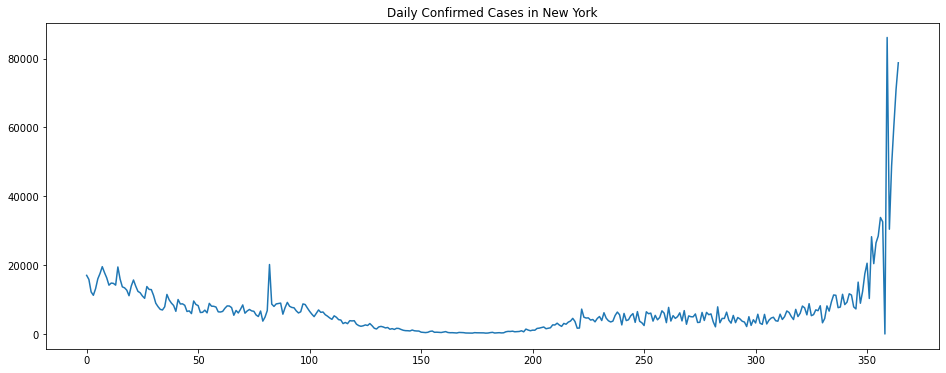

New York -0.34671955143779065 9.501489803105475e-12
New York -0.7322132376762575 1.6065515664138709e-62
pearson from average New York -0.4358866417352524 4.4234598657644985e-18
spearman from average New York -0.7850682459419644 2.922030923167072e-76


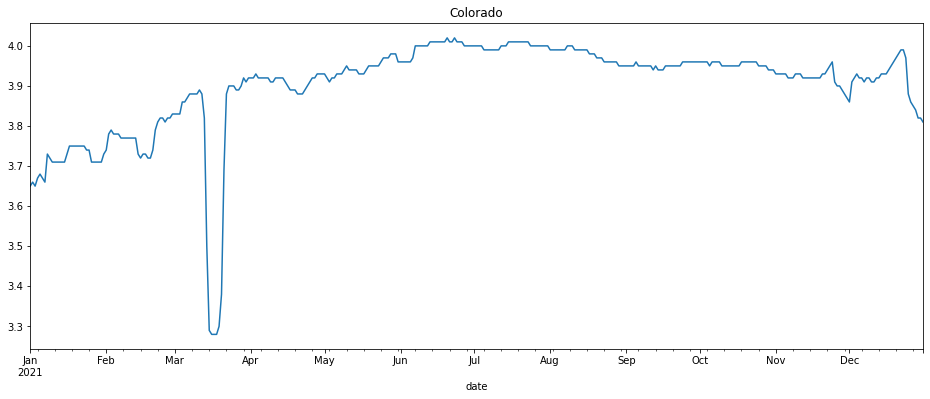

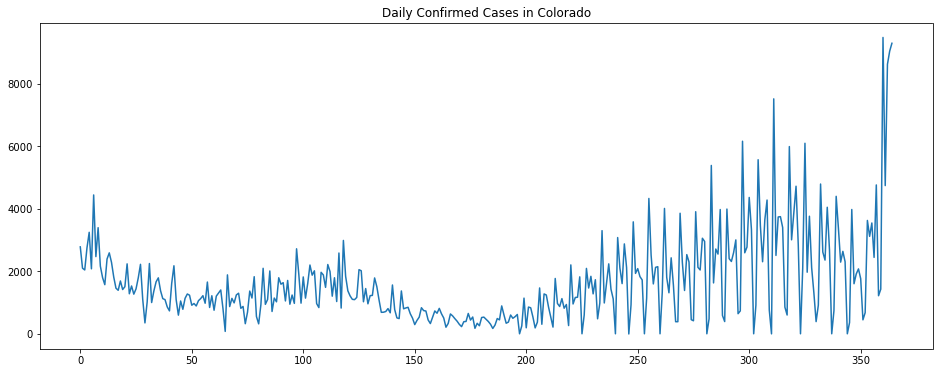

Colorado -0.09218157449894657 0.07860599985229609
Colorado -0.34204089222526846 1.8691060090263975e-11
pearson from average Colorado -0.100401002847122 0.057367821365318816
spearman from average Colorado -0.367162668687752 6.722634577027185e-13


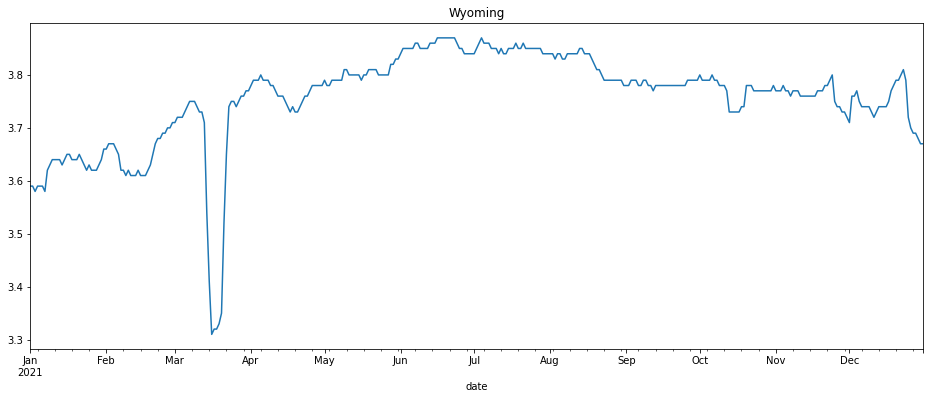

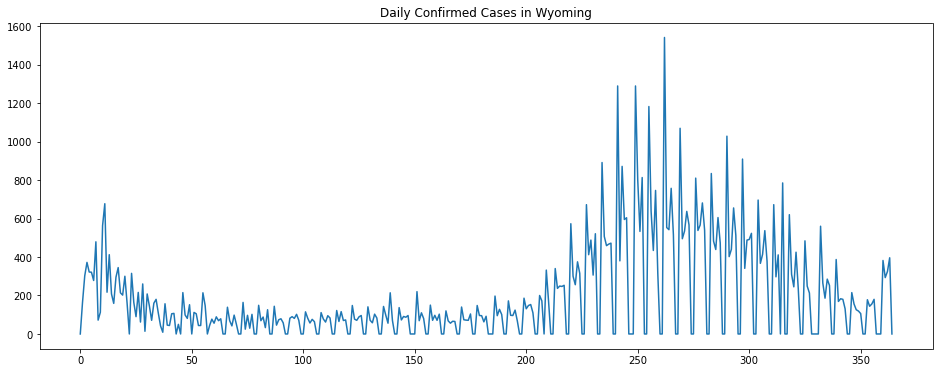

Wyoming 0.03128718415661955 0.5512845162918999
Wyoming -0.06921830862855352 0.18701504686271725
pearson from average Wyoming 0.053908594962250825 0.30839256118546327
spearman from average Wyoming -0.045425035402337915 0.39082455652902914


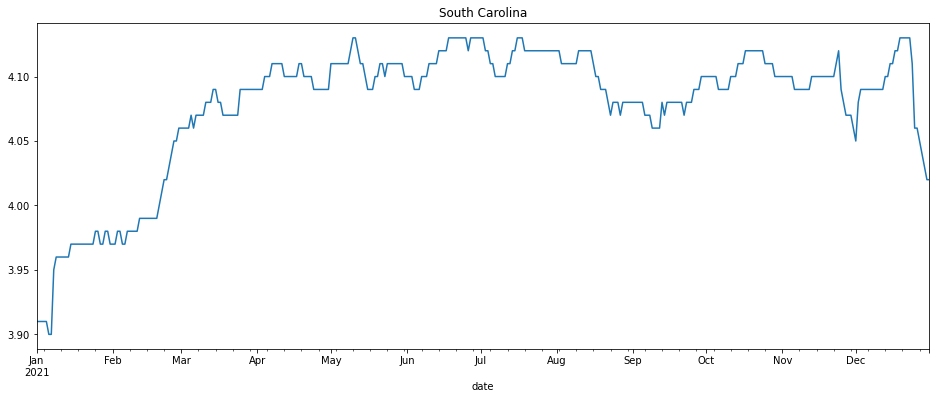

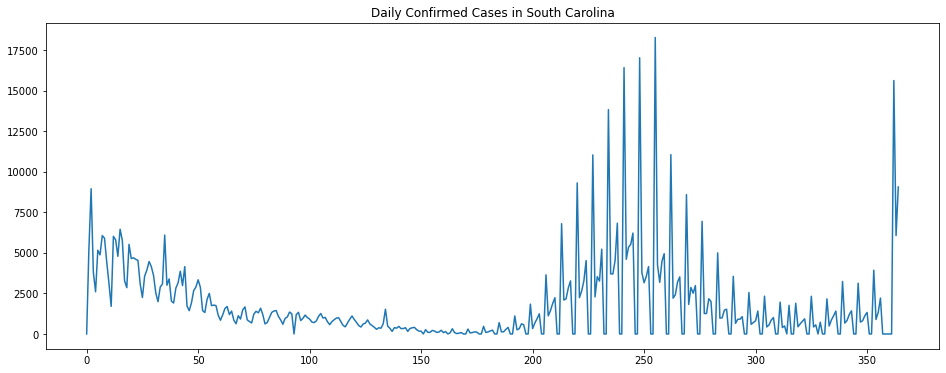

South Carolina -0.3964131270937252 3.480756420786161e-15
South Carolina -0.47324795327201463 9.039954489692386e-22
pearson from average South Carolina -0.6320821409131332 1.9217995506072344e-41
spearman from average South Carolina -0.634617439804435 7.349835140000509e-42


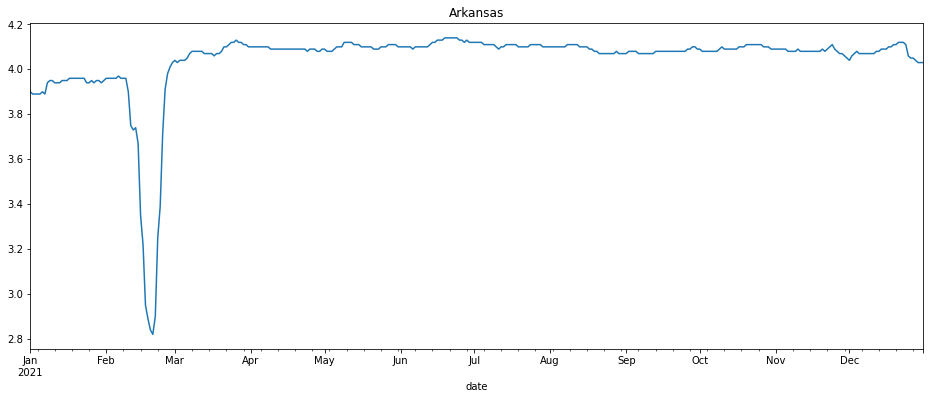

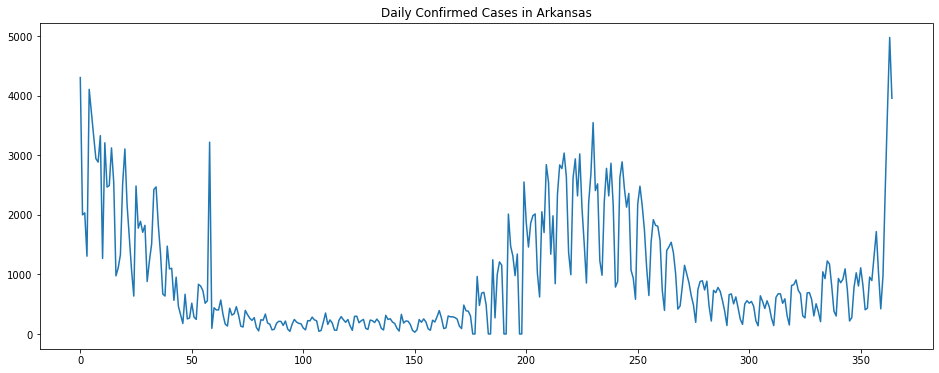

Arkansas -0.057556580681773585 0.2727486906821483
Arkansas -0.3718529210538223 2.0589562633117845e-13
pearson from average Arkansas -0.06906224822316961 0.1917095312626821
spearman from average Arkansas -0.40490657444185746 1.3505183952218508e-15


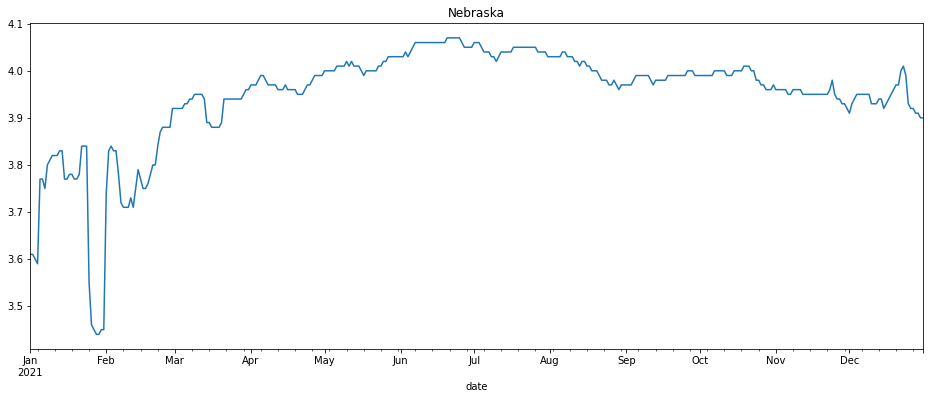

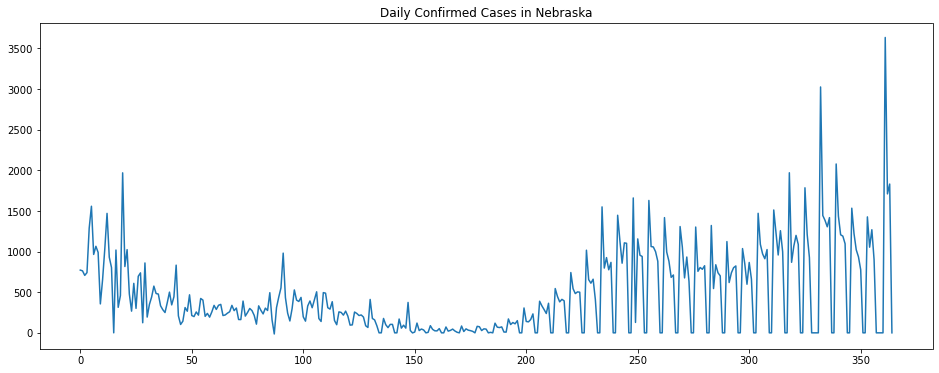

Nebraska -0.19575195709893117 0.00016756457231885267
Nebraska -0.36375473488442284 7.343261395576689e-13
pearson from average Nebraska -0.336171975899747 6.209630492520962e-11
spearman from average Nebraska -0.5698472523976142 2.6869556063413237e-32


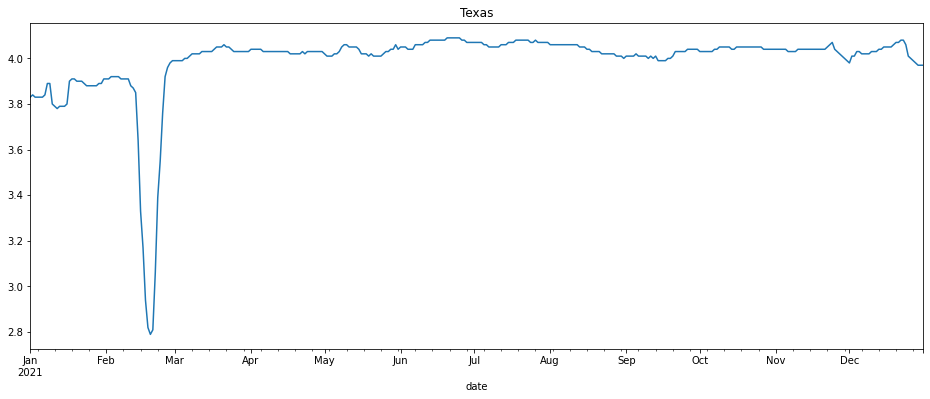

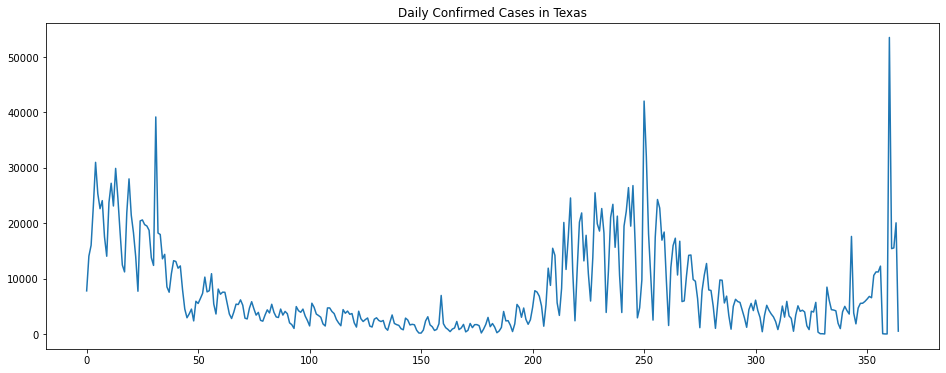

Texas -0.15528207815923611 0.0029342154146044684
Texas -0.4175515777912104 7.835200536734647e-17
pearson from average Texas -0.21499654793602324 3.9991272586067505e-05
spearman from average Texas -0.5027777077407756 2.1399944989788235e-24


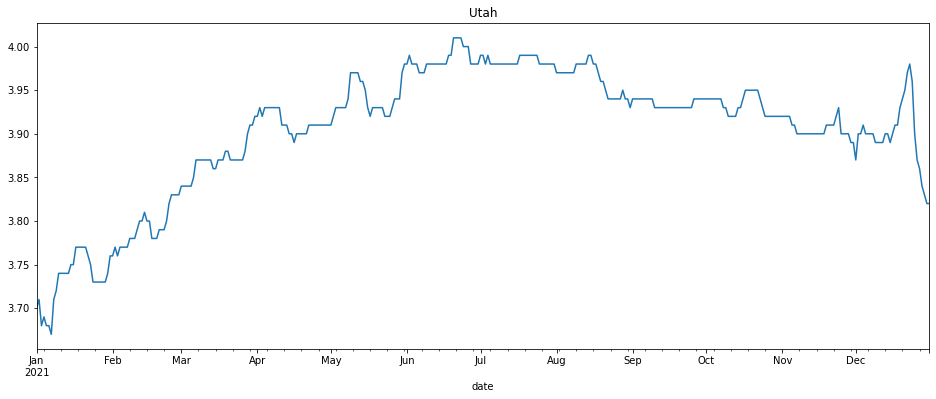

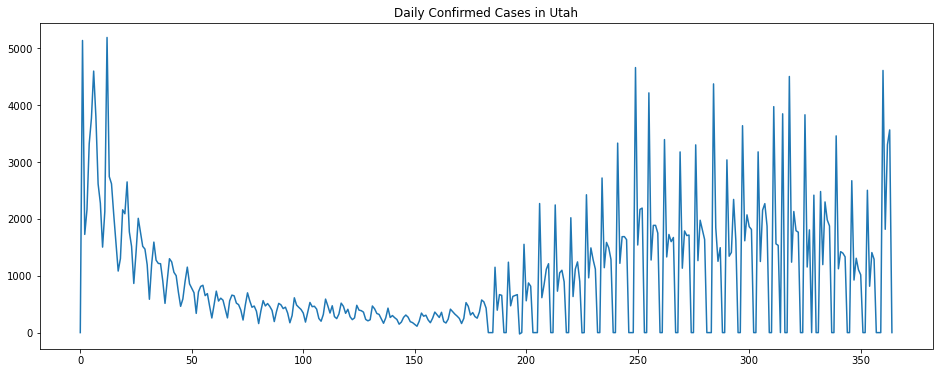

Utah -0.3432489848997696 1.571189690494289e-11
Utah -0.2995648220591298 5.278078773045312e-09
pearson from average Utah -0.5227926617000845 1.4269578572751038e-26
spearman from average Utah -0.40530482459980394 1.2593966829638464e-15


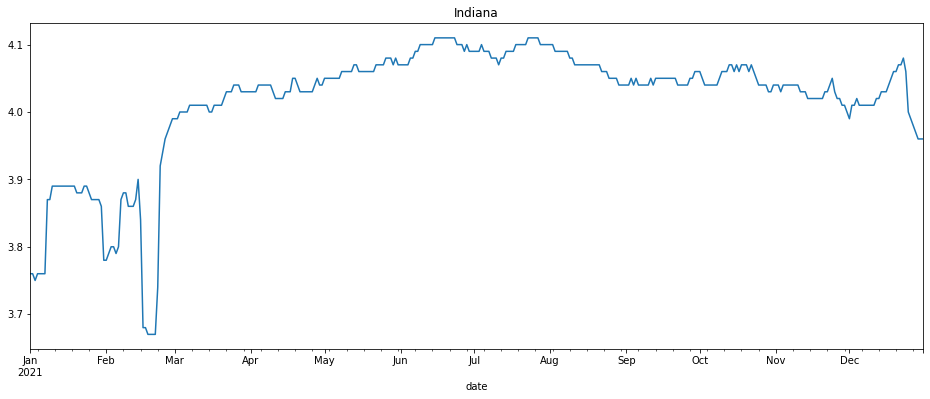

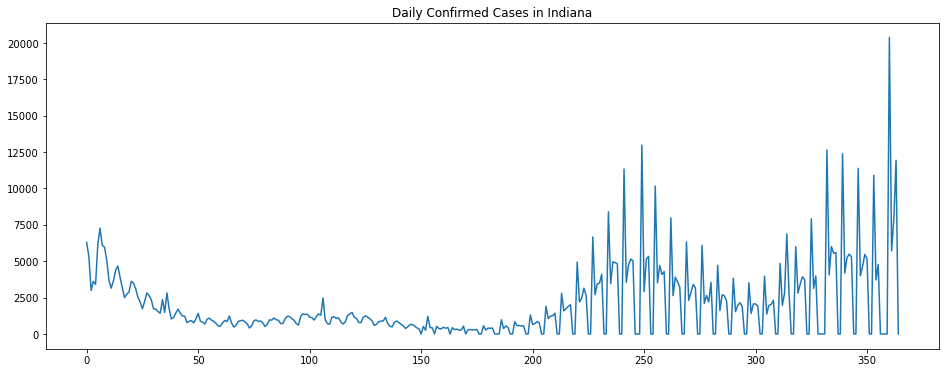

Indiana -0.17944484592304055 0.0005720531493972697
Indiana -0.35934623373985464 1.4455861399187235e-12
pearson from average Indiana -0.25679319602747175 8.159720428577607e-07
spearman from average Indiana -0.4409477394879332 1.6405998739284018e-18


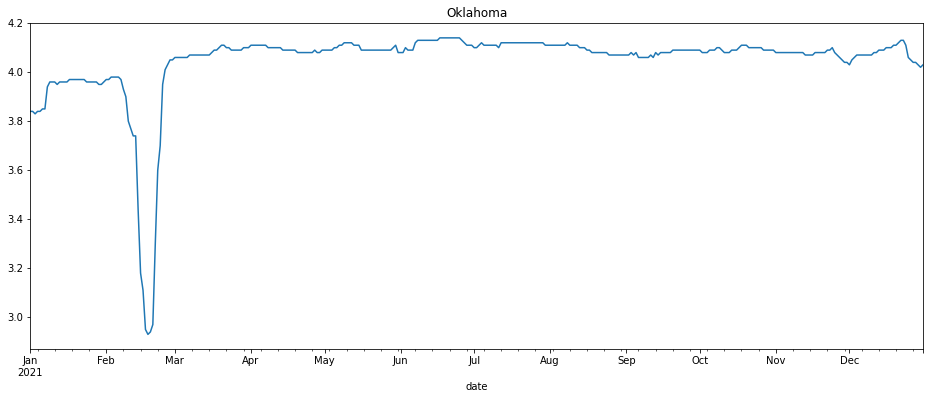

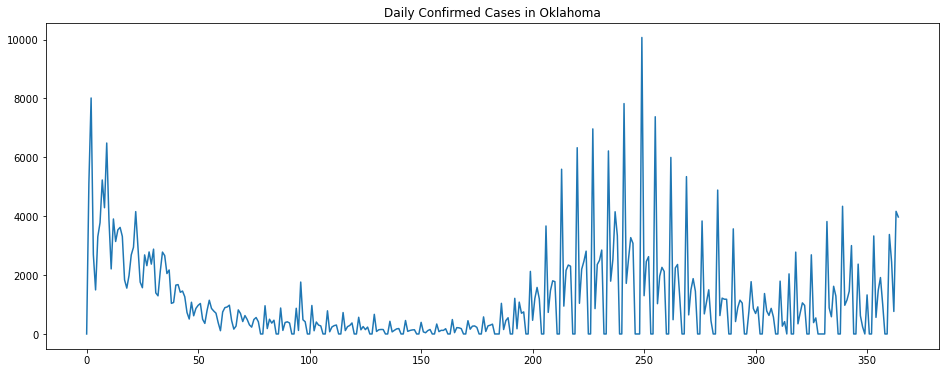

Oklahoma -0.11965790235349924 0.02222851165051531
Oklahoma -0.3679652784154958 3.8079743867794214e-13
pearson from average Oklahoma -0.19136674719286315 0.00026532185149764
spearman from average Oklahoma -0.5230930808832226 1.3202028292777403e-26


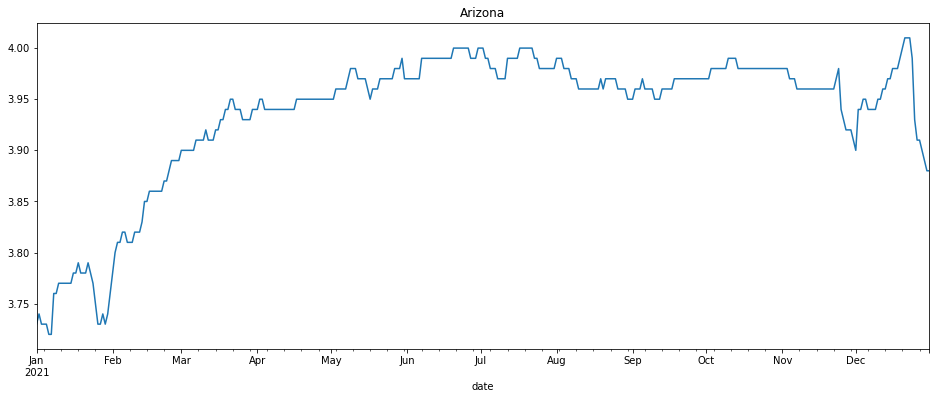

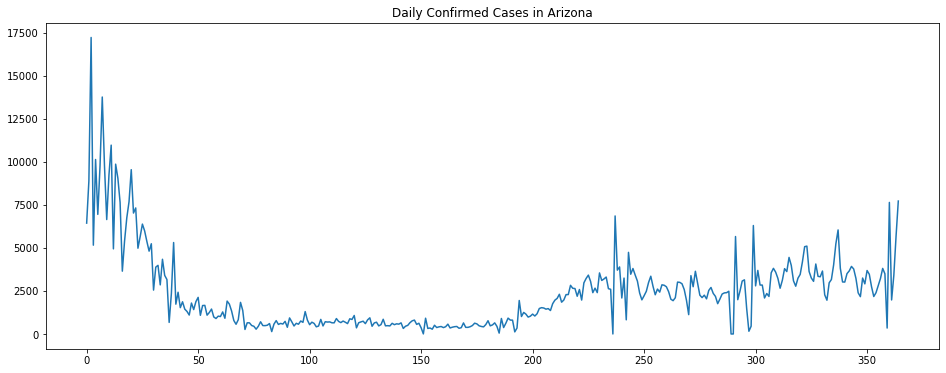

Arizona -0.6192555958868363 5.054254367520859e-40
Arizona -0.33739932809671114 3.616860702808718e-11
pearson from average Arizona -0.6653369637487097 3.029435509863408e-47
spearman from average Arizona -0.38402210311861645 4.630391773107321e-14


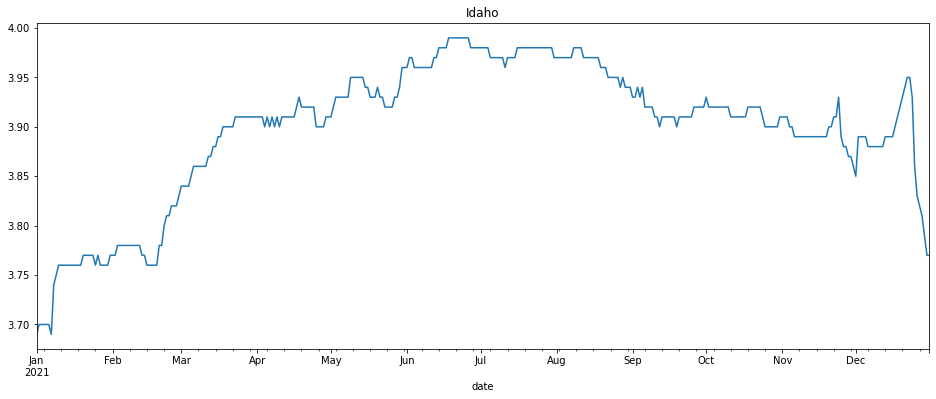

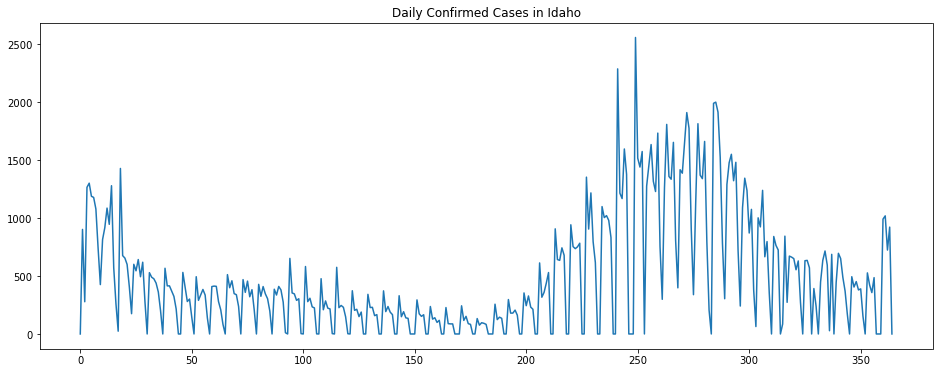

Idaho -0.12222216504939129 0.019501389026059916
Idaho -0.24248008049123077 2.7749125073031714e-06
pearson from average Idaho -0.15743994845724543 0.002777607789358915
spearman from average Idaho -0.35442240184672186 4.588197288809738e-12


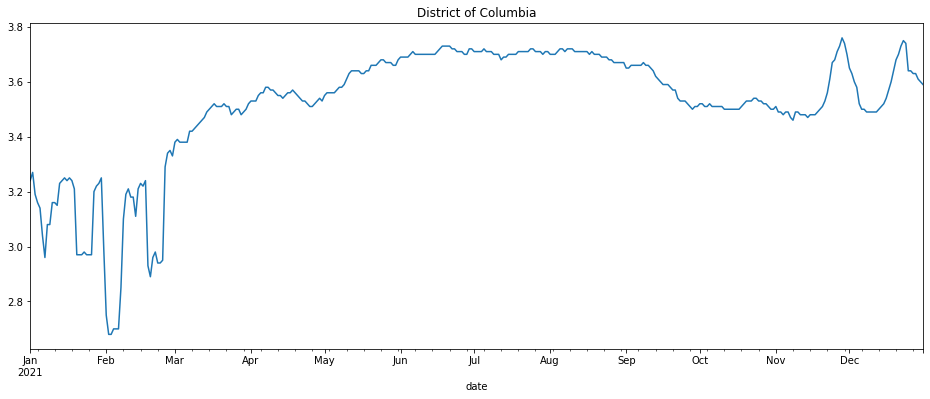

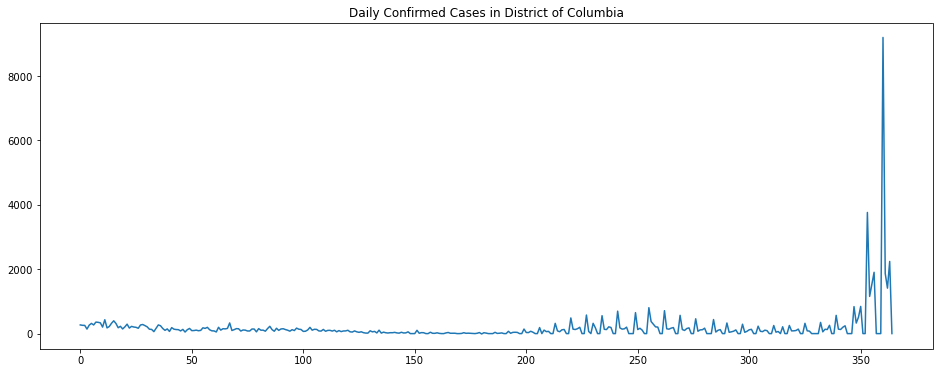

District of Columbia 0.0019039067735339352 0.971083532145022
District of Columbia -0.4114543818479644 2.406229811660436e-16
pearson from average District of Columbia -0.02034365650679484 0.7008652354086429
spearman from average District of Columbia -0.4549523025807892 9.657858091221702e-20


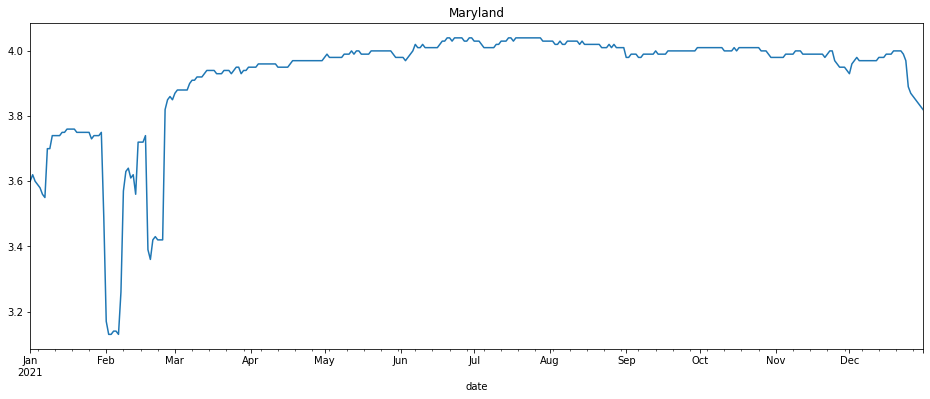

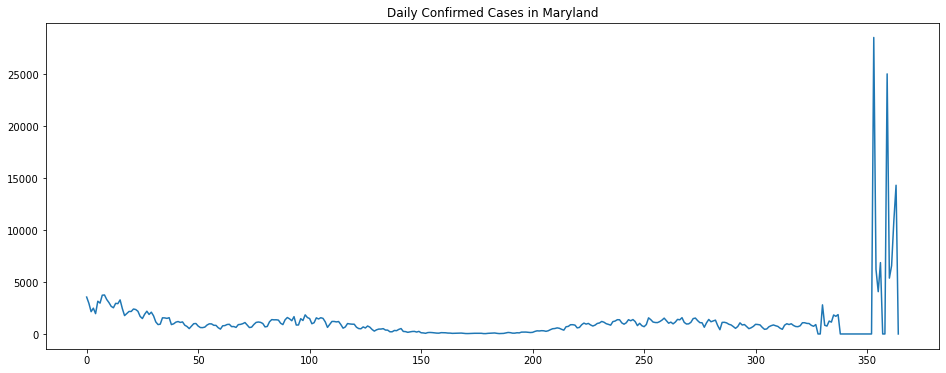

Maryland -0.140658848752171 0.007114018650488577
Maryland -0.4716246975106696 1.2979546407111231e-21
pearson from average Maryland -0.21994366759217765 2.6177571081571576e-05
spearman from average Maryland -0.5305751547294472 1.856182015992649e-27


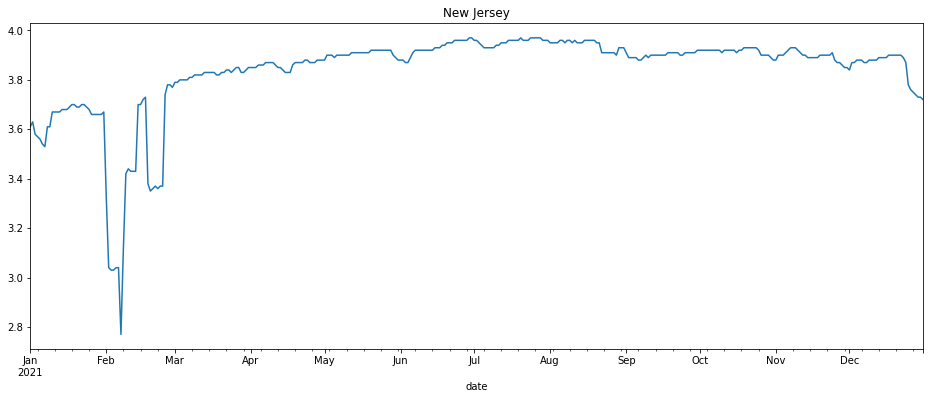

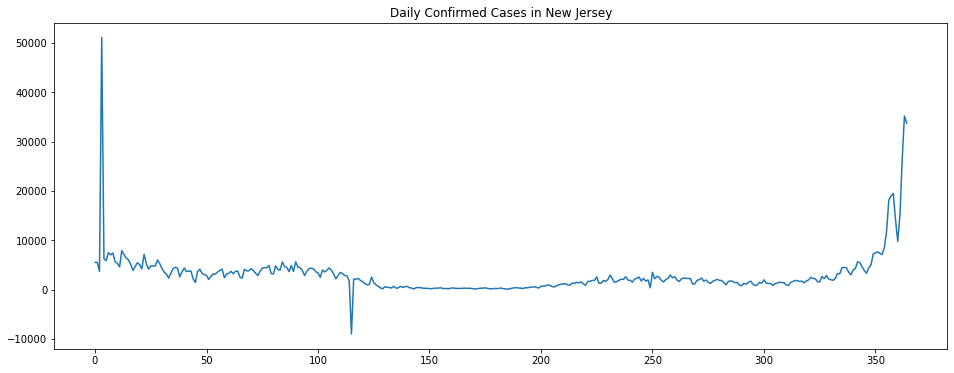

New Jersey -0.2688177817937243 1.8438193858137576e-07
New Jersey -0.7555430212318769 1.1533586019186556e-68
pearson from average New Jersey -0.36684654780310255 7.058087657476172e-13
spearman from average New Jersey -0.7686396714104075 2.937234346785403e-71


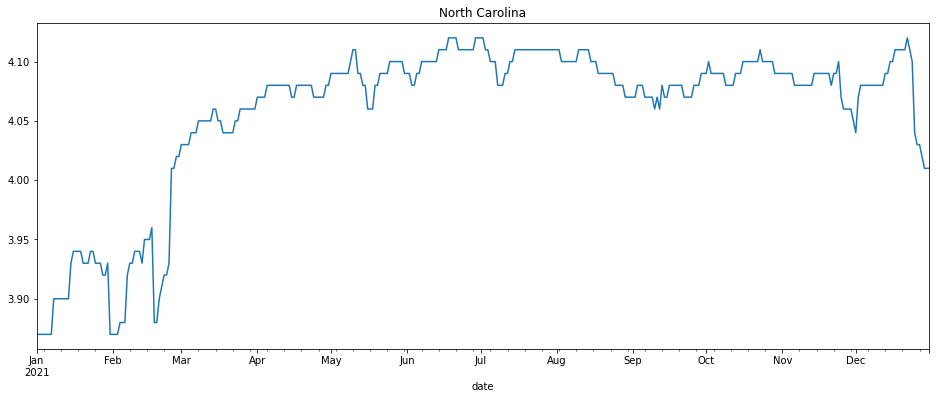

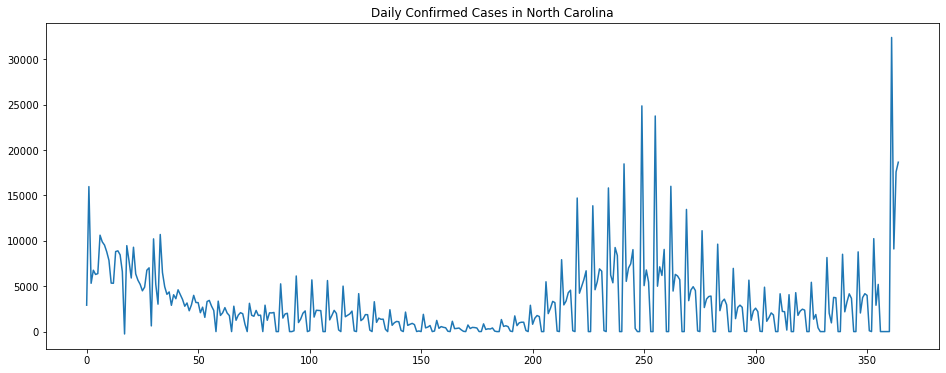

North Carolina -0.3178353591187889 5.189948760513085e-10
North Carolina -0.3254132090058955 1.8917060184298561e-10
pearson from average North Carolina -0.5200947639042464 2.8587990027863525e-26
spearman from average North Carolina -0.4694329966139173 4.486604859635271e-21


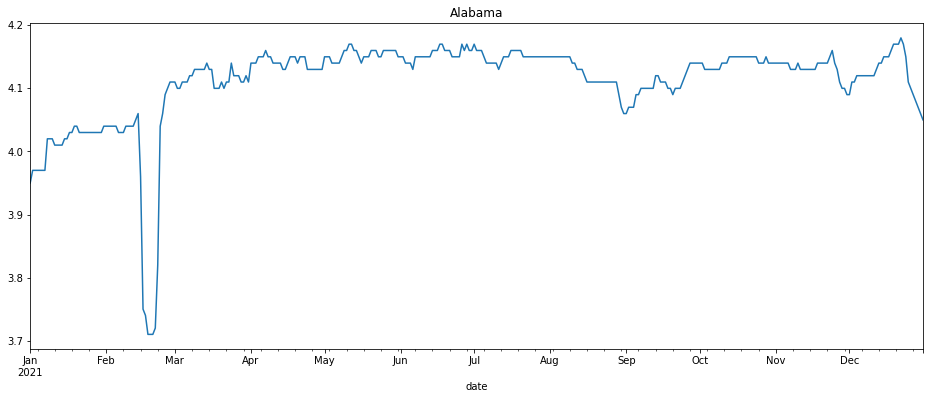

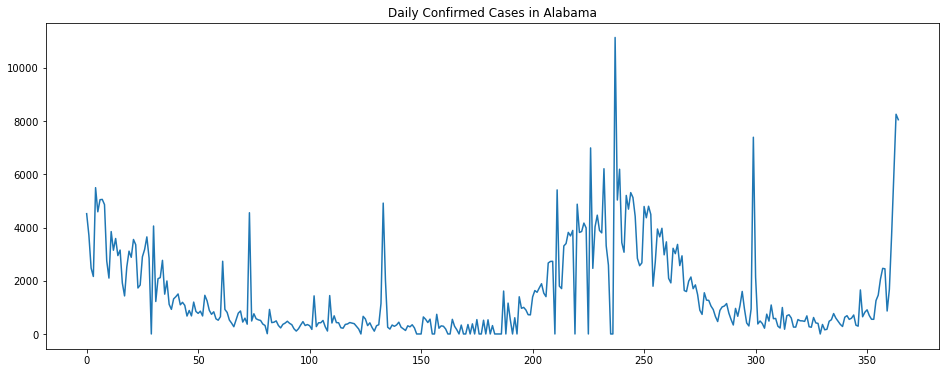

Alabama -0.25758506887090143 6.078492957072257e-07
Alabama -0.47326995816244055 8.995616391279658e-22
pearson from average Alabama -0.31139267622391426 1.6391125473864074e-09
spearman from average Alabama -0.5428464991096348 6.675089341761959e-29


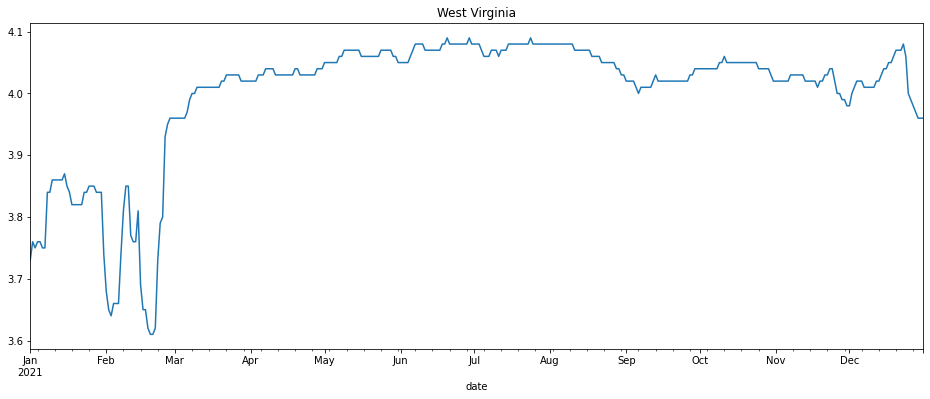

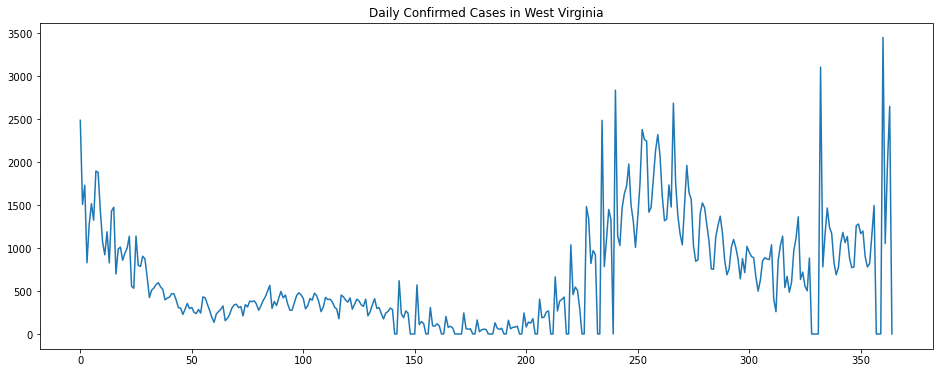

West Virginia -0.14767681410802647 0.004695682995677924
West Virginia -0.4217419901423426 3.5756783558838166e-17
pearson from average West Virginia -0.1455990957980653 0.005712714729983235
spearman from average West Virginia -0.4888599941569999 5.769365037701943e-23


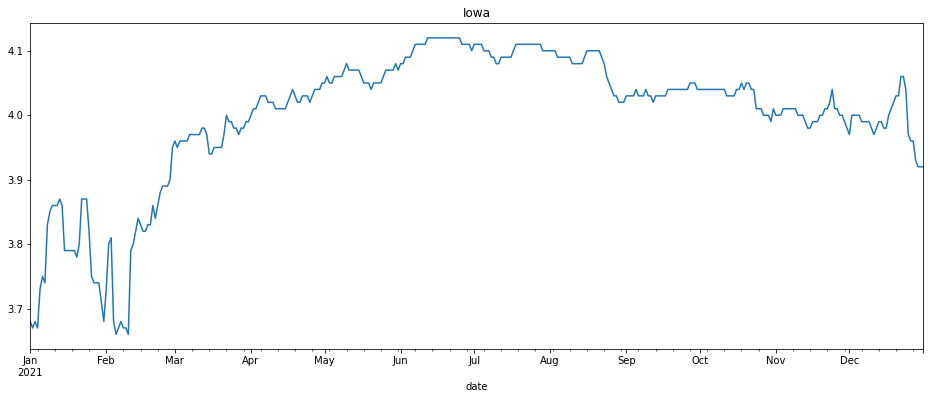

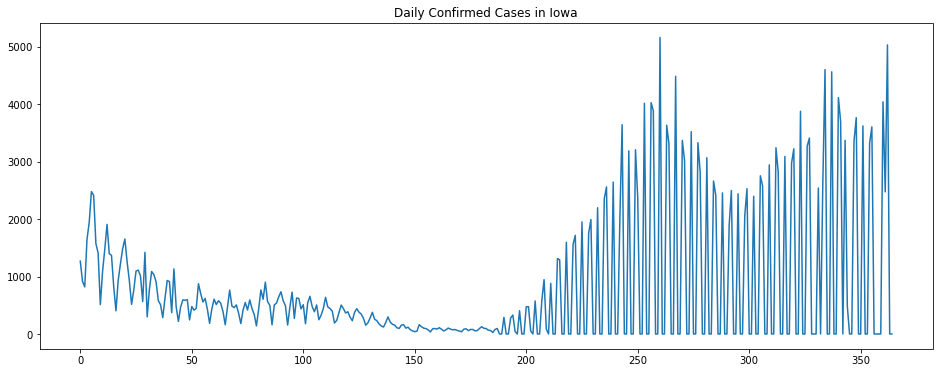

Iowa -0.14827637801907131 0.0045282428970647055
Iowa -0.3630068752059532 8.243445411034748e-13
pearson from average Iowa -0.30012814525273745 6.5897240084329875e-09
spearman from average Iowa -0.5064005402054641 8.85360132556236e-25


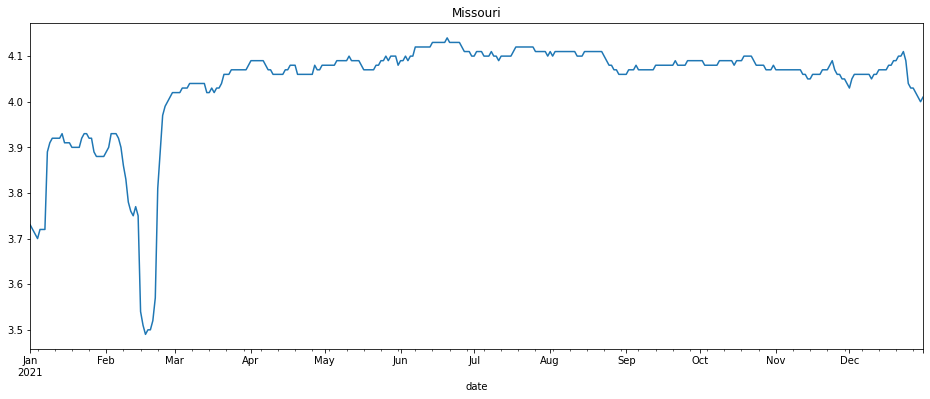

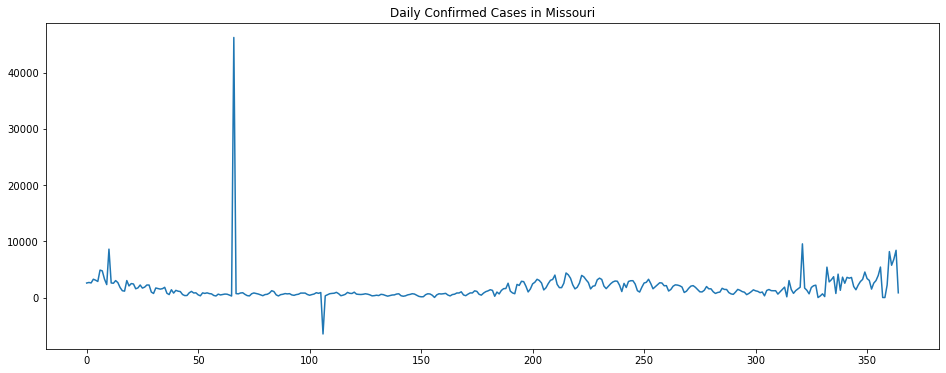

Missouri -0.027977537076263922 0.5941851912897205
Missouri -0.027529138887098493 0.6001124524897594
pearson from average Missouri -0.03766631904096729 0.4768125851332538
spearman from average Missouri -0.08909739948898546 0.09186879363958432


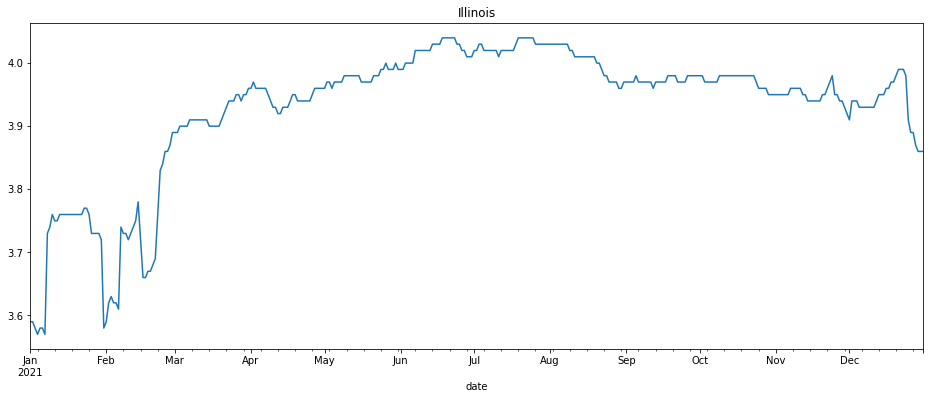

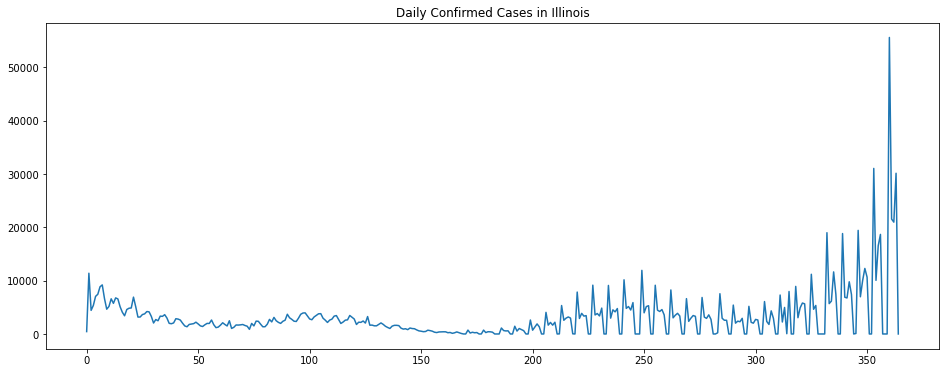

Illinois -0.15782470184736086 0.0024956584239679766
Illinois -0.36685312406364506 4.533462338163853e-13
pearson from average Illinois -0.2448687782521811 2.6649007301484116e-06
spearman from average Illinois -0.47818698732611553 6.52857538784015e-22


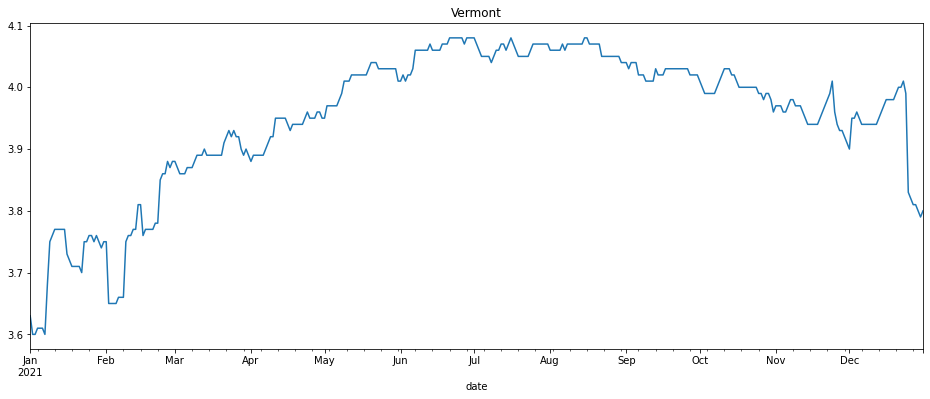

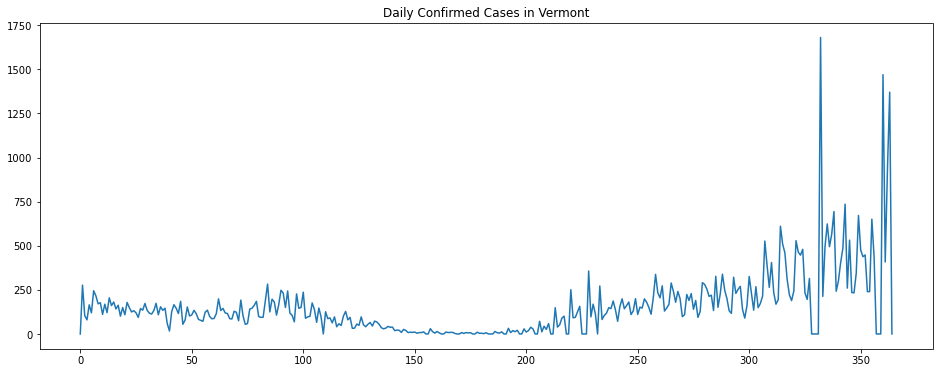

Vermont -0.16827630697169477 0.0012512694332508653
Vermont -0.379721488715643 5.78178540897804e-14
pearson from average Vermont -0.2137726985314811 4.4345048718091976e-05
spearman from average Vermont -0.43701219869294233 3.552922973024524e-18


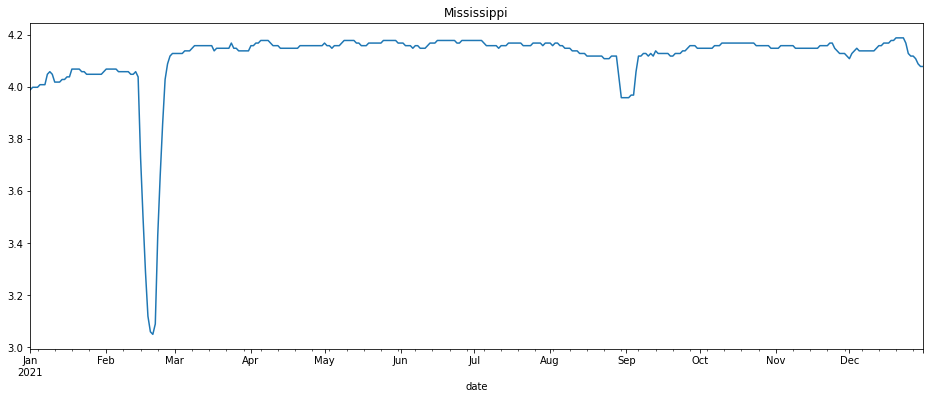

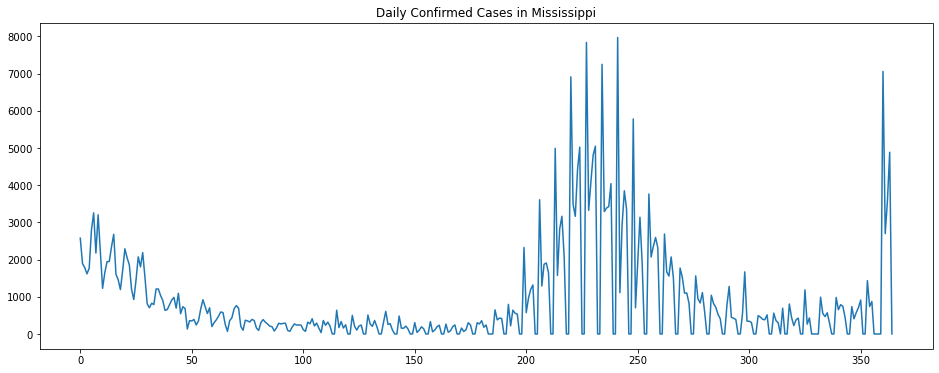

Mississippi -0.0855961495489851 0.1025319830368813
Mississippi -0.4247449945200129 2.0242600728067623e-17
pearson from average Mississippi -0.13248316618437514 0.01198696612992586
spearman from average Mississippi -0.6215746391606277 9.39991516909985e-40


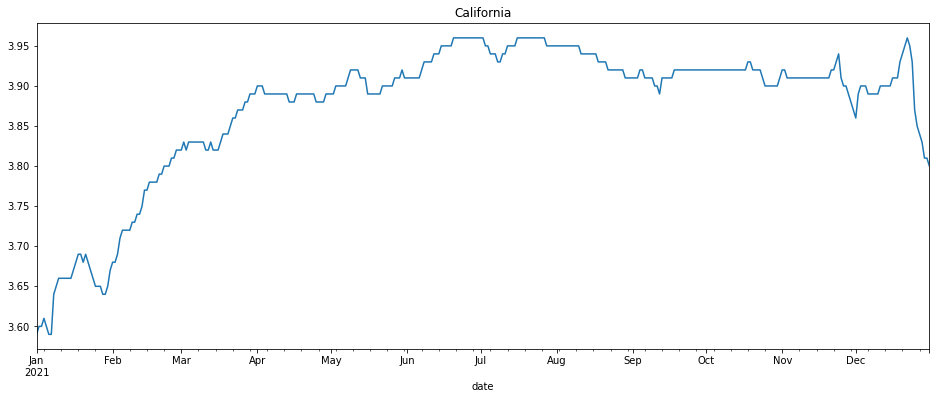

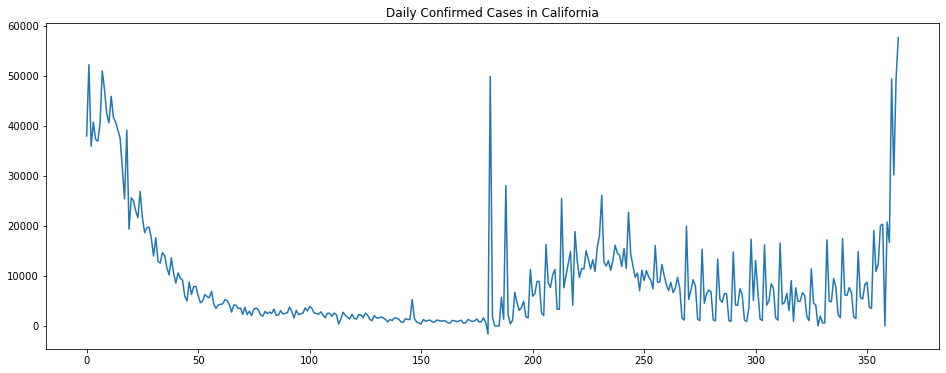

California -0.608737460650699 2.2146723002098608e-38
California -0.25770772618526916 6.001604371965566e-07
pearson from average California -0.6692793321685679 5.539797483063276e-48
spearman from average California -0.11426597421055532 0.030420250877171064


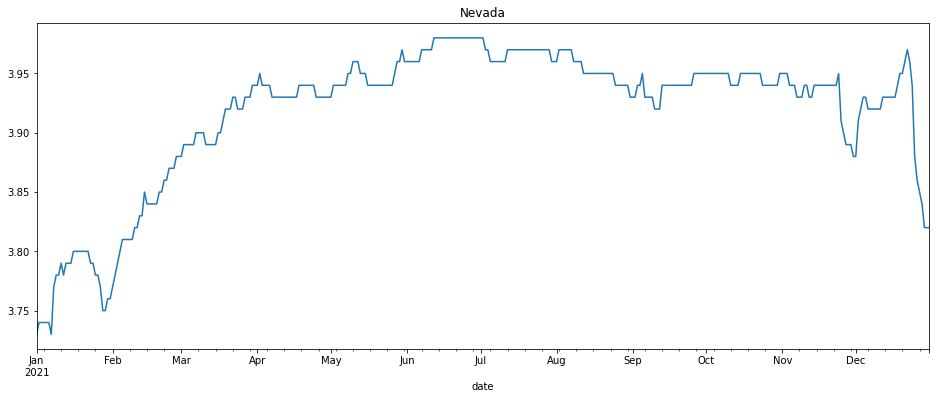

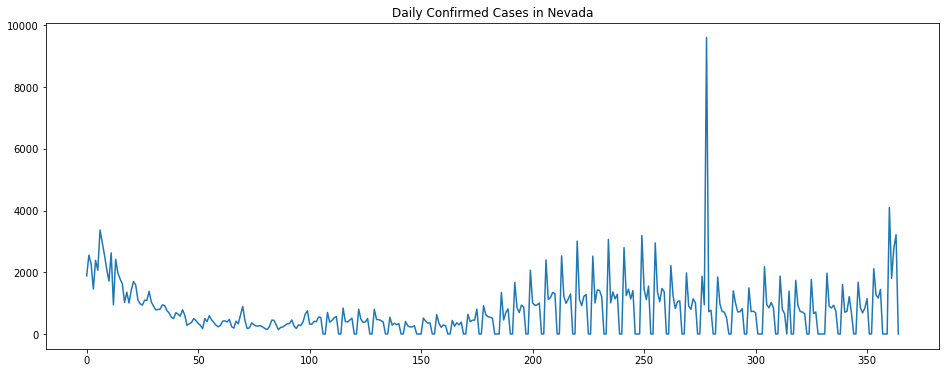

Nevada -0.2791023960814657 5.8910942529199655e-08
Nevada -0.17924998048649143 0.0005801521368265883
pearson from average Nevada -0.43102049619084354 1.1302795903523918e-17
spearman from average Nevada -0.15669143540954567 0.002911462525305401


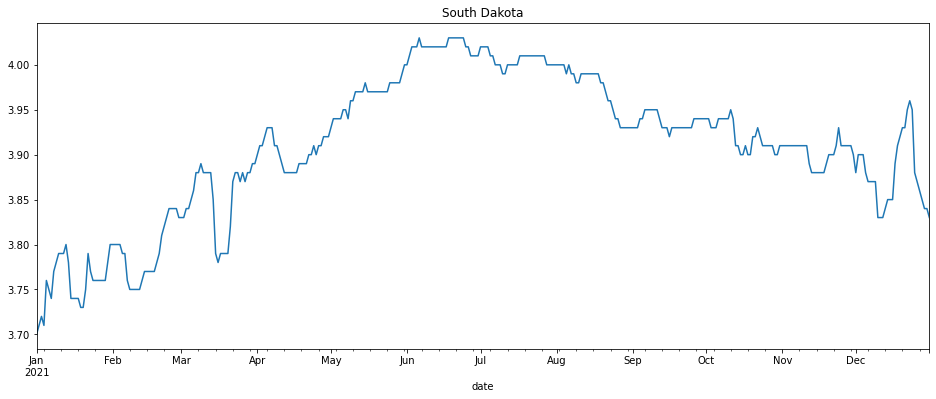

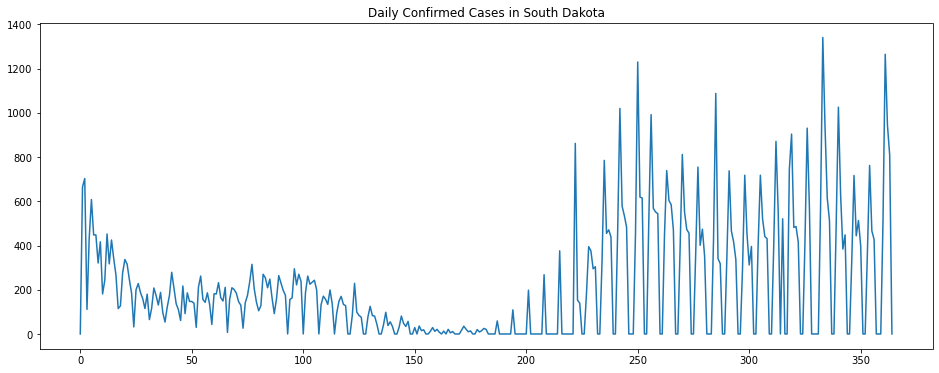

South Dakota -0.23830945698725903 4.149008997801641e-06
South Dakota -0.4042489437825278 8.800690282053854e-16
pearson from average South Dakota -0.3795821183332072 9.509795520144307e-14
spearman from average South Dakota -0.4721438386546394 2.4846214694142822e-21


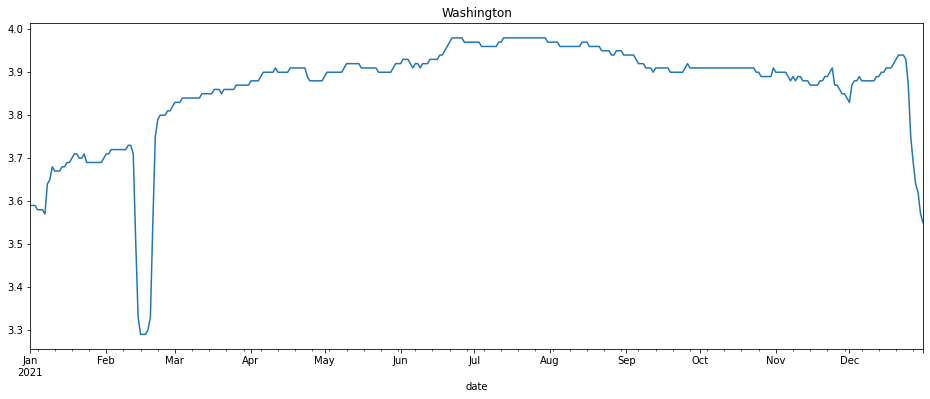

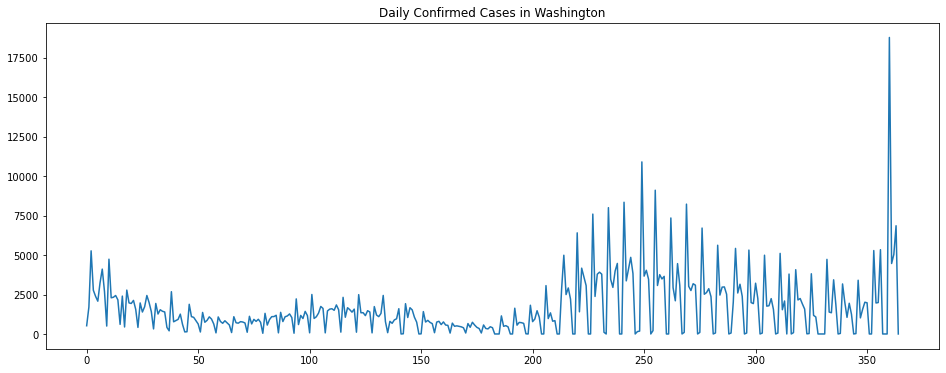

Washington -0.04773281314031491 0.3631788414489641
Washington -0.09962632818024335 0.05722831615842439
pearson from average Washington 0.007102197877199692 0.8933236341814912
spearman from average Washington -0.03481593264808434 0.5108166885974831


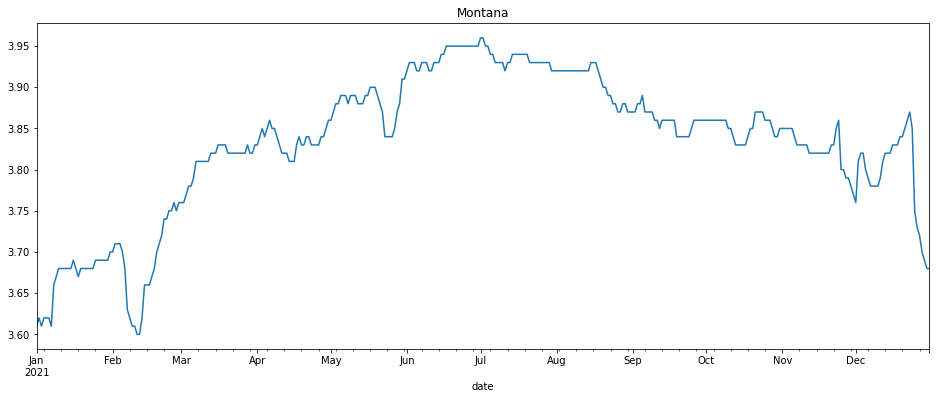

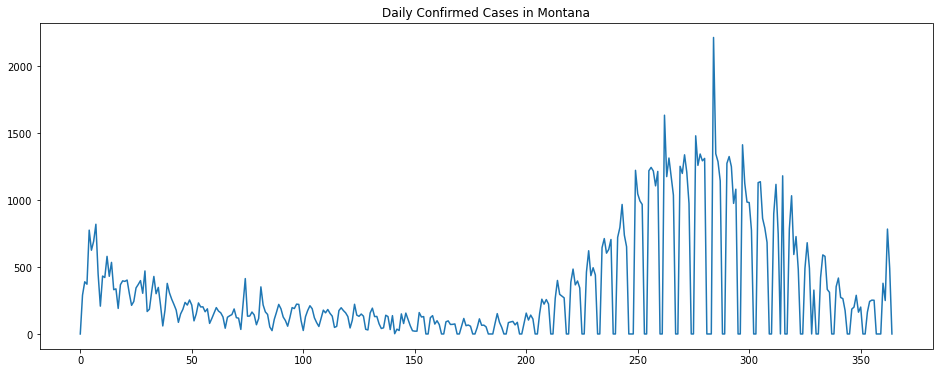

Montana -0.09119990377220723 0.08185497263656408
Montana -0.2687592991951605 1.8555721569015804e-07
pearson from average Montana -0.134486888691691 0.010745300987190707
spearman from average Montana -0.3719772199577155 3.181136929596679e-13


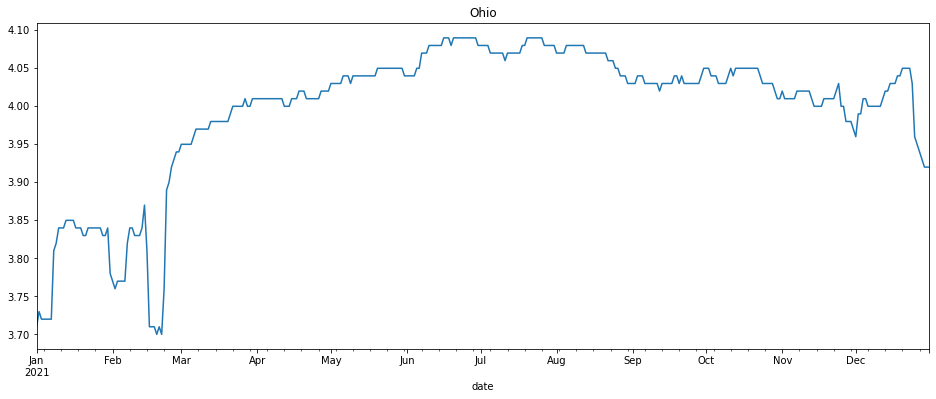

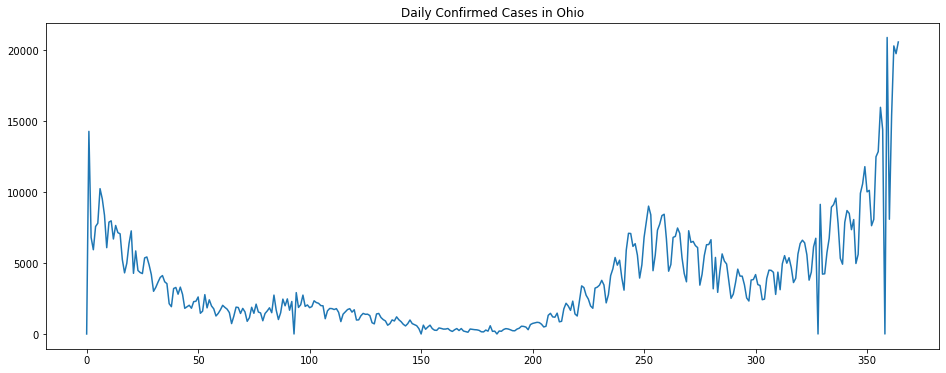

Ohio -0.25614878993289975 7.052186309436945e-07
Ohio -0.43602966061342907 2.266799731544605e-18
pearson from average Ohio -0.2705626623213536 1.9298825275665318e-07
spearman from average Ohio -0.4855757068238505 1.2283165866722213e-22


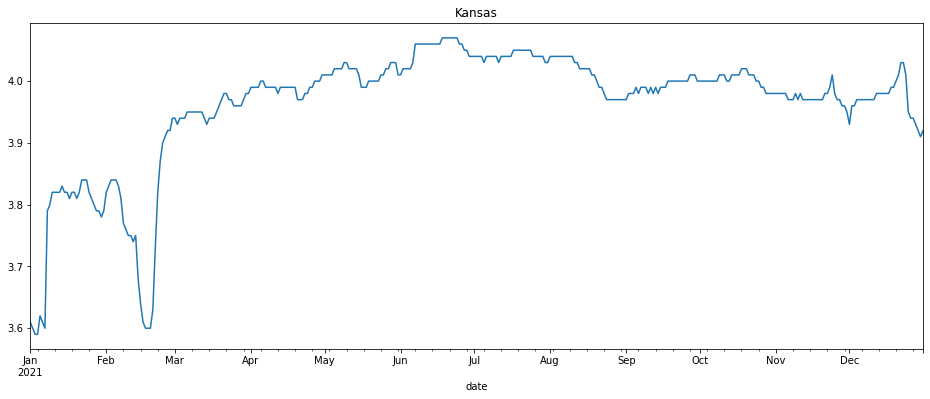

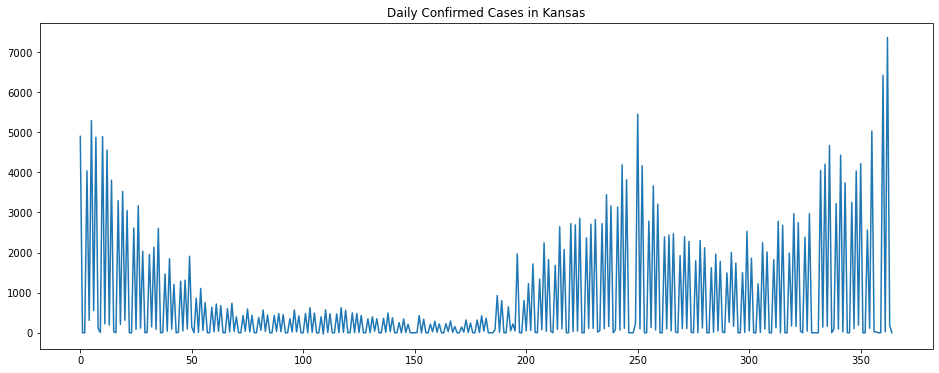

Kansas -0.18232108464042637 0.00046407777858365585
Kansas -0.13777963316410255 0.008393194012295152
pearson from average Kansas -0.36436137122578444 1.0330749340344127e-12
spearman from average Kansas -0.46123533325892124 2.5959816881271288e-20


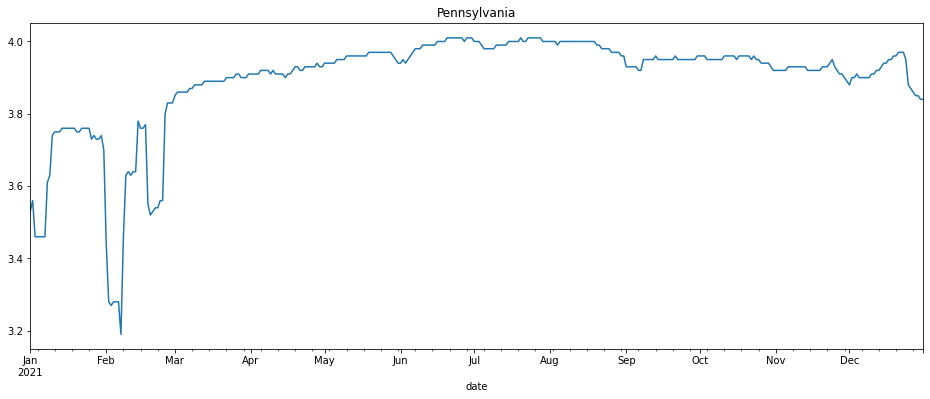

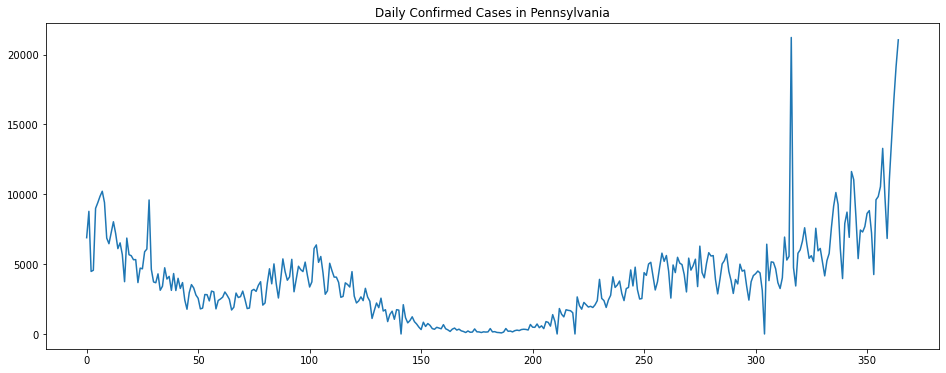

Pennsylvania -0.26372214916554615 3.1893623631693704e-07
Pennsylvania -0.5727499296791931 3.3408598375952956e-33
pearson from average Pennsylvania -0.3084845641857987 2.3608624177999007e-09
spearman from average Pennsylvania -0.5923722101759024 2.2260867960181726e-35


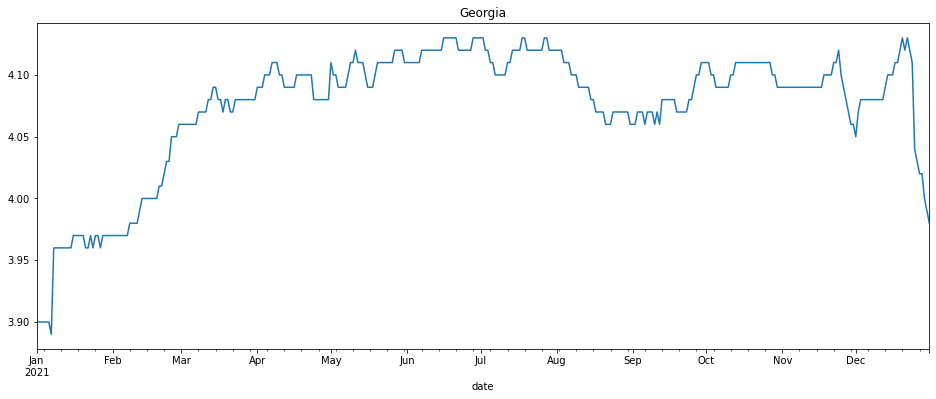

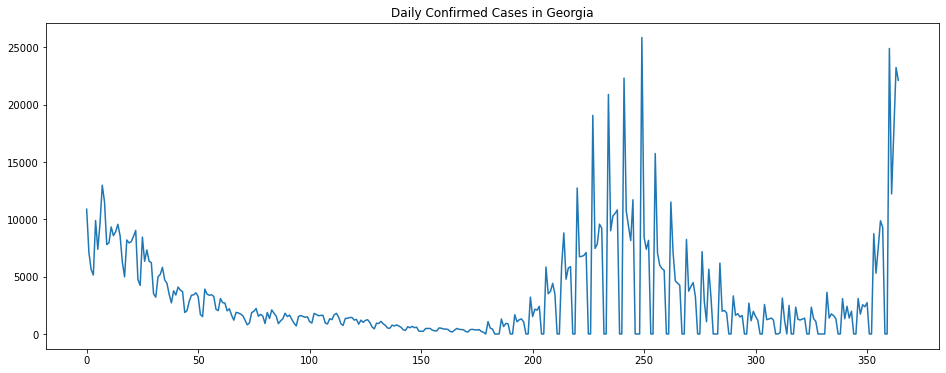

Georgia -0.45709267732934783 3.0403654060989326e-20
Georgia -0.48518316907169823 5.957229730270391e-23
pearson from average Georgia -0.6199494531361469 1.6932576343657102e-39
spearman from average Georgia -0.6793399754966273 6.427760835003171e-50


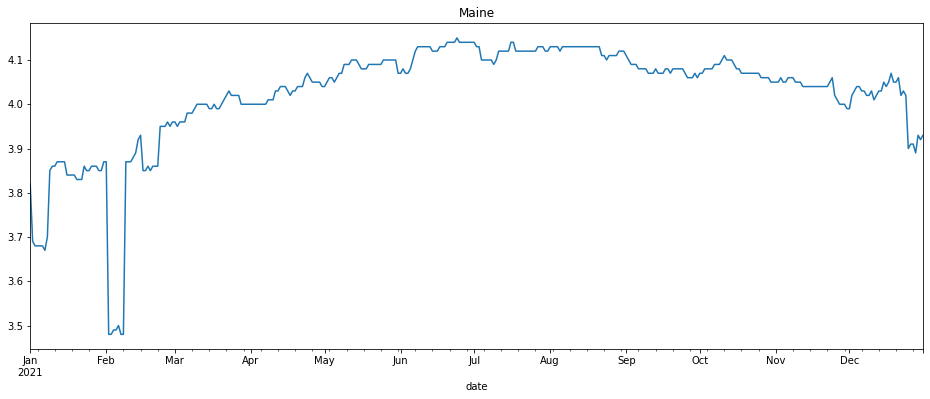

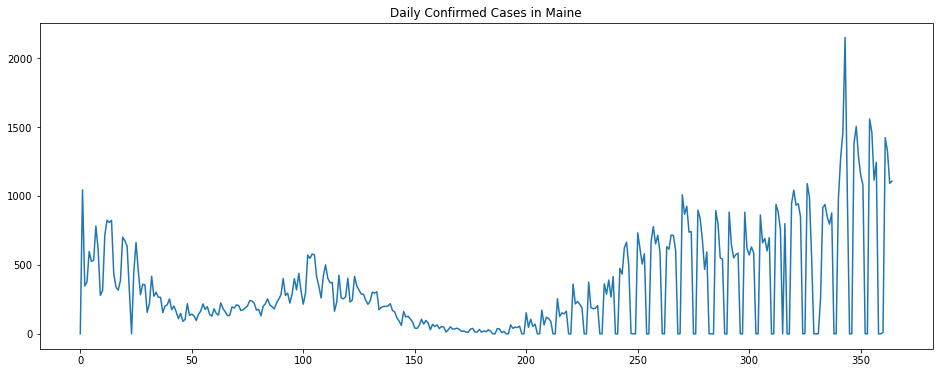

Maine -0.14929538911239604 0.004255982208808733
Maine -0.35057723361514215 5.39273236385537e-12
pearson from average Maine -0.217379631607466 3.264663359784144e-05
spearman from average Maine -0.48572250662328875 1.1877274584250714e-22


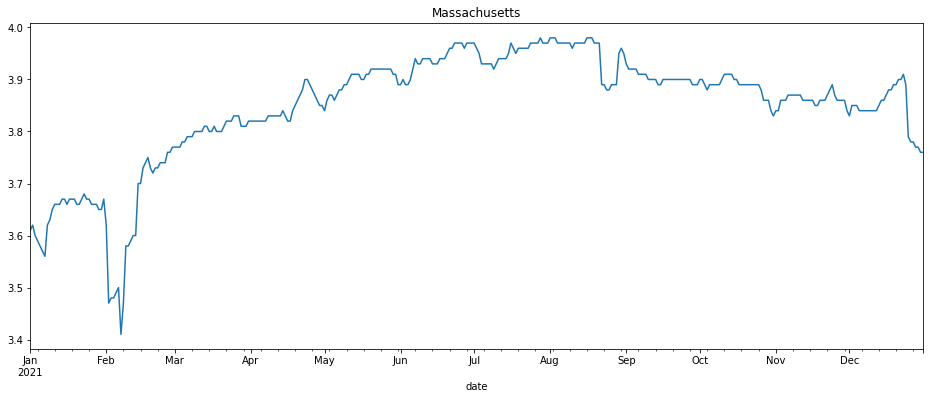

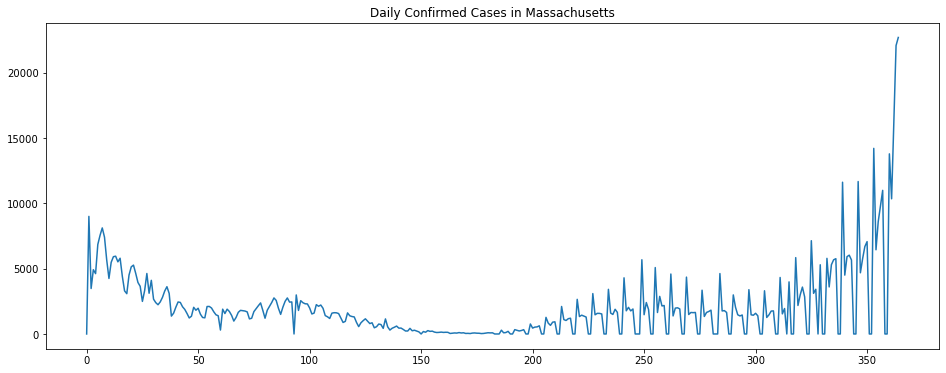

Massachusetts -0.3561407710704351 2.350154676076014e-12
Massachusetts -0.5357294170196176 1.6784951621990756e-28
pearson from average Massachusetts -0.5193552169765017 3.45490175423386e-26
spearman from average Massachusetts -0.7455211985325301 6.987600349720931e-65


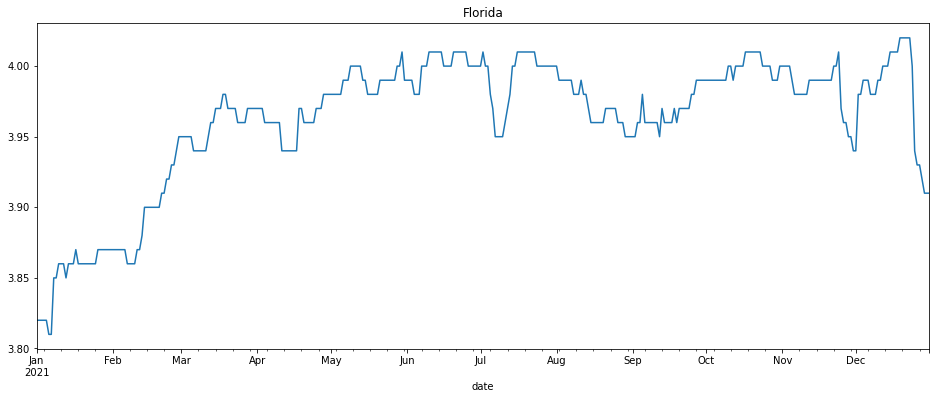

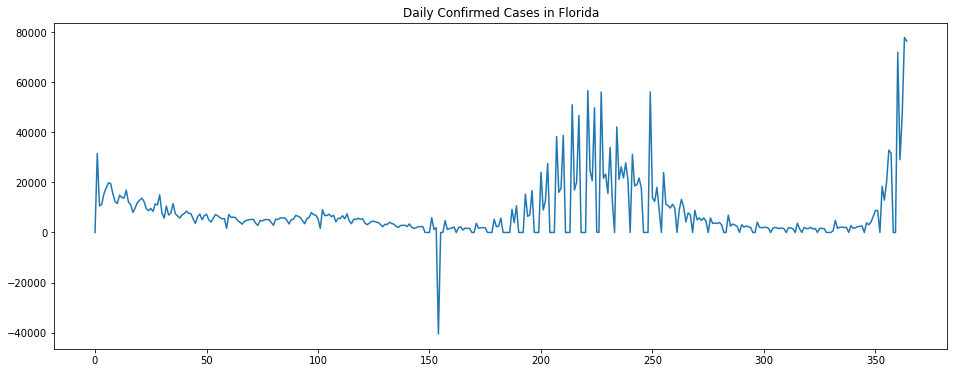

Florida -0.2195918788025886 2.309218714844918e-05
Florida -0.44086512027936253 8.649204976238776e-19
pearson from average Florida -0.30295530293275313 4.673260321831487e-09
spearman from average Florida -0.4863902299078665 1.0191753100622814e-22


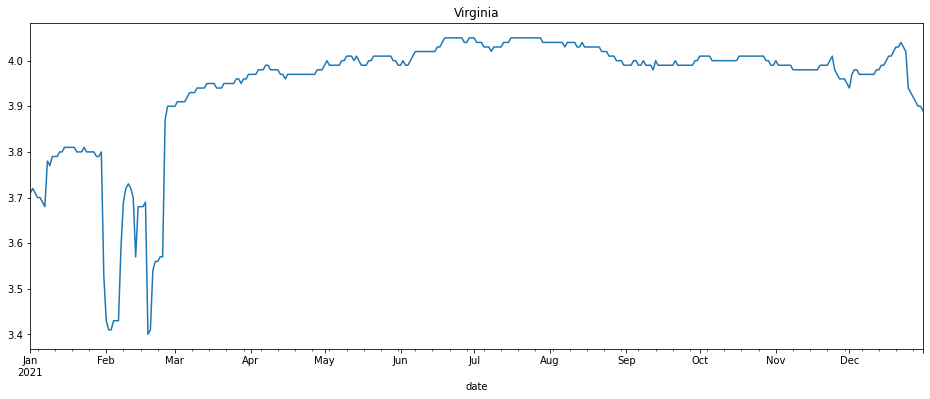

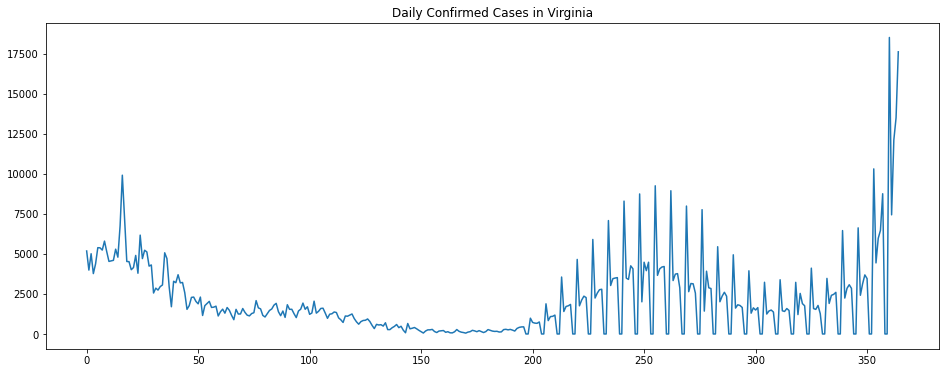

Virginia -0.2848786497684773 3.0399139024780387e-08
Virginia -0.43604865983399627 2.258302457666061e-18
pearson from average Virginia -0.4337096169499878 6.7429113123264966e-18
spearman from average Virginia -0.48889423414569183 5.723845592068009e-23


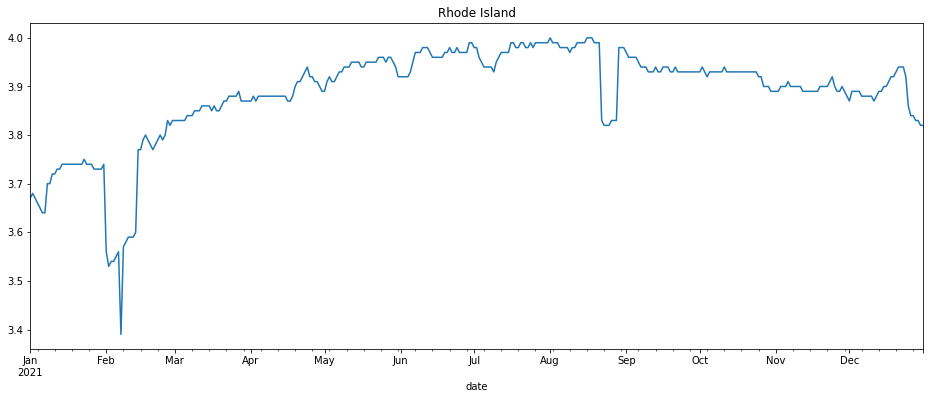

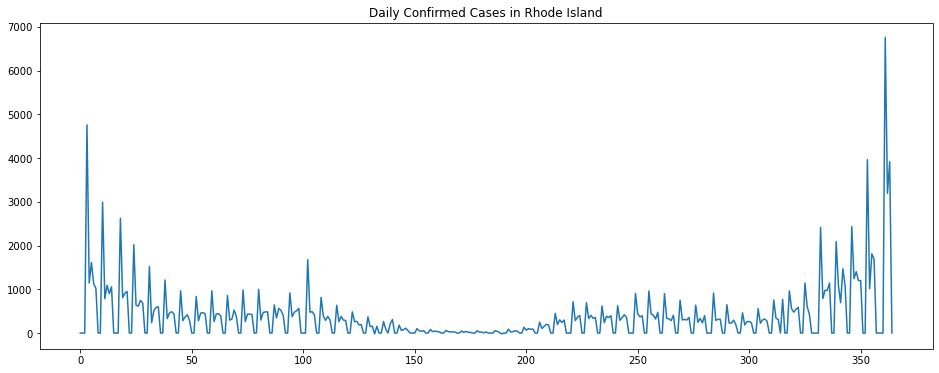

Rhode Island -0.2500980911588556 1.3059872265006919e-06
Rhode Island -0.27748152817506005 7.073775258849792e-08
pearson from average Rhode Island -0.47178582113006606 2.6871241275594644e-21
spearman from average Rhode Island -0.751323551676966 2.0428326385628317e-66


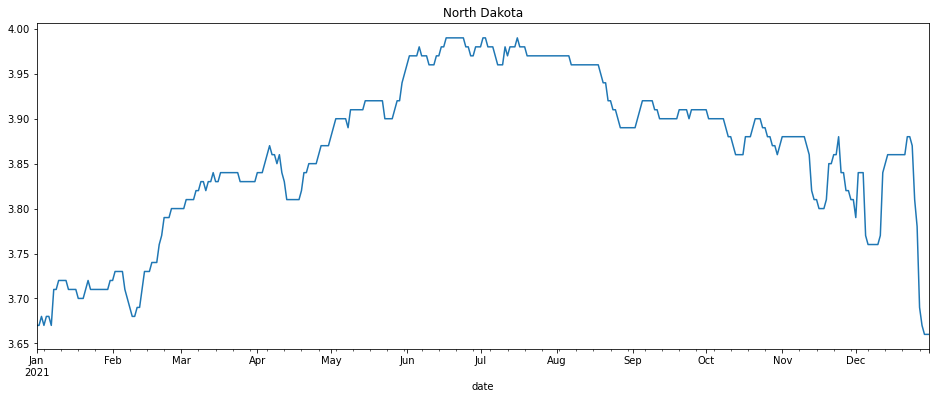

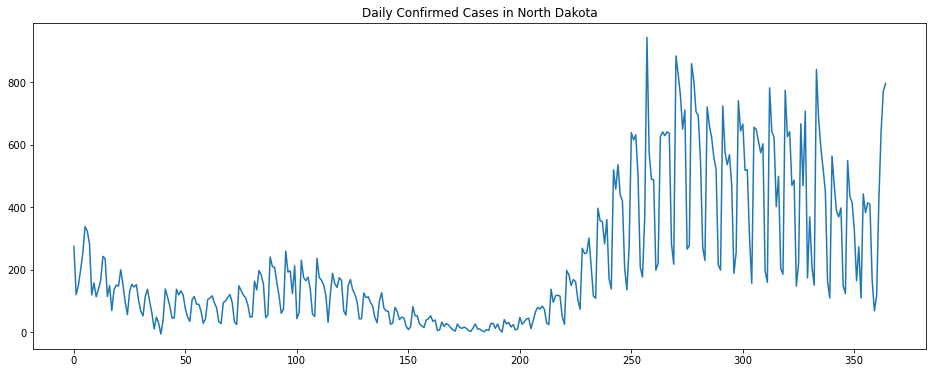

North Dakota -0.10763480025910636 0.03985188435355917
North Dakota -0.30128367380964466 4.27209285984561e-09
pearson from average North Dakota -0.09513261808405117 0.07181254888070275
spearman from average North Dakota -0.3170232638821029 7.995940943134323e-10


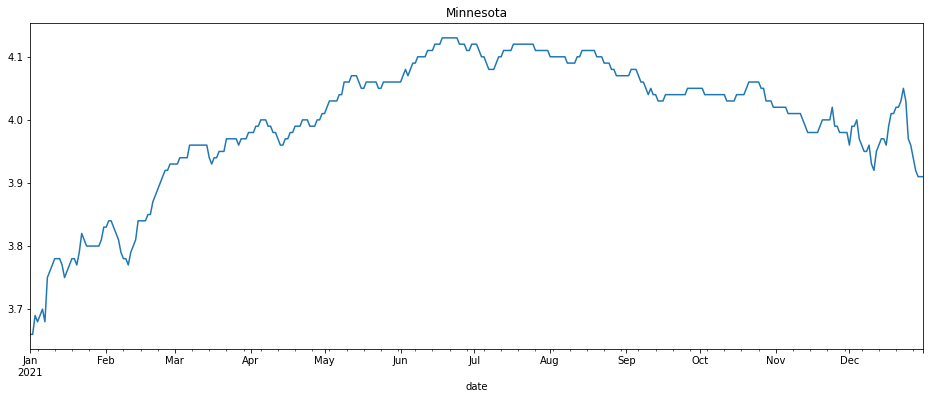

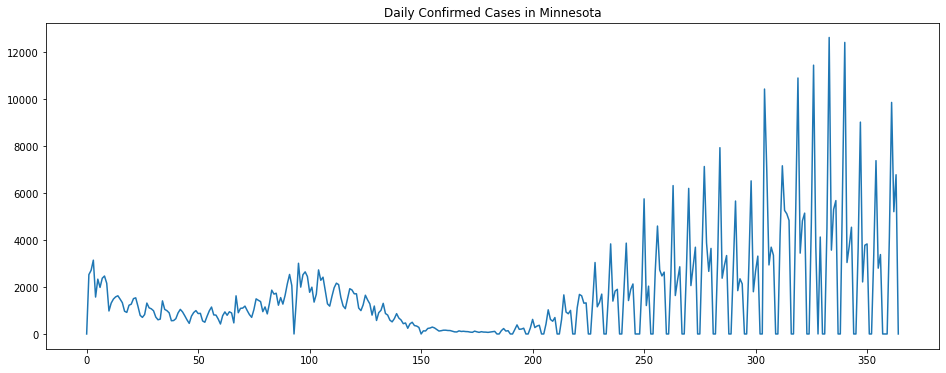

Minnesota -0.11189443849014886 0.032587974196294
Minnesota -0.3265303981104278 1.6262876540019517e-10
pearson from average Minnesota -0.17262390653690454 0.0010233165377837809
spearman from average Minnesota -0.3998087423733979 3.2754867844252767e-15


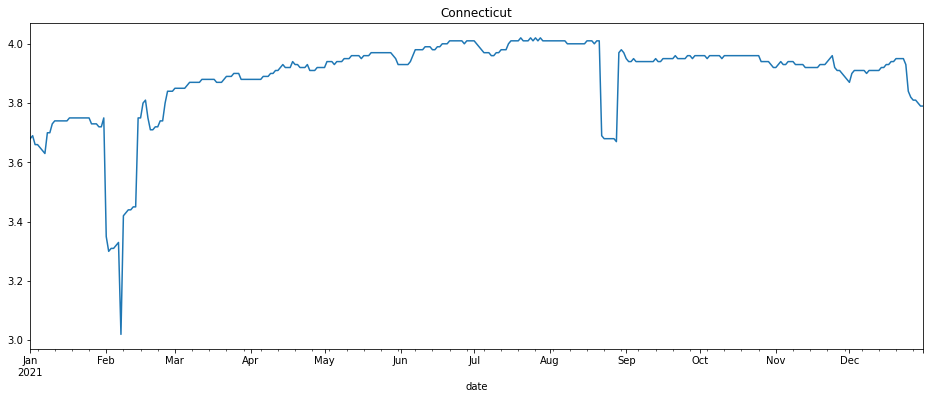

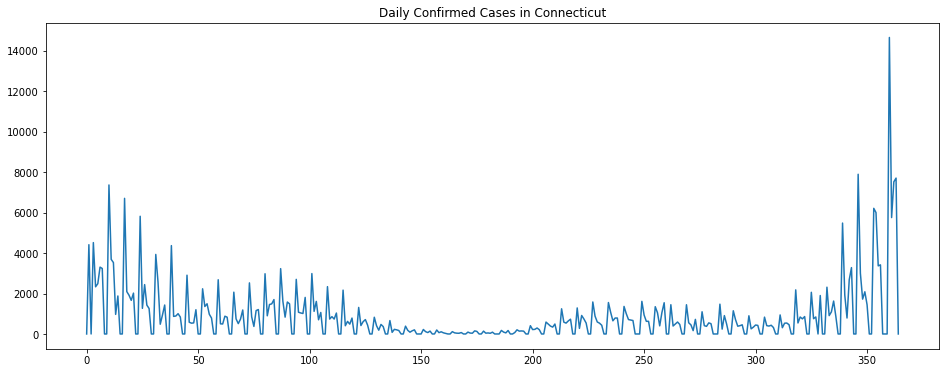

Connecticut -0.25072832850324506 1.2256927223444657e-06
Connecticut -0.3179663314503426 5.101419165062401e-10
pearson from average Connecticut -0.43970681250202837 2.0954998408861878e-18
spearman from average Connecticut -0.7969045669756077 3.8053615358712195e-80


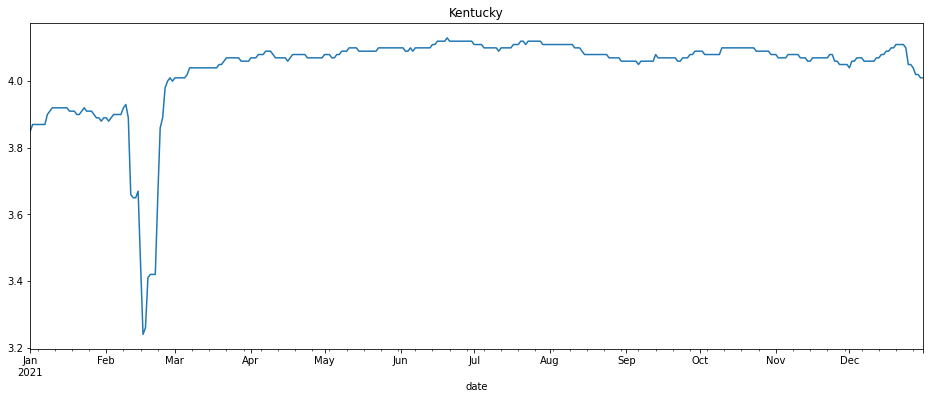

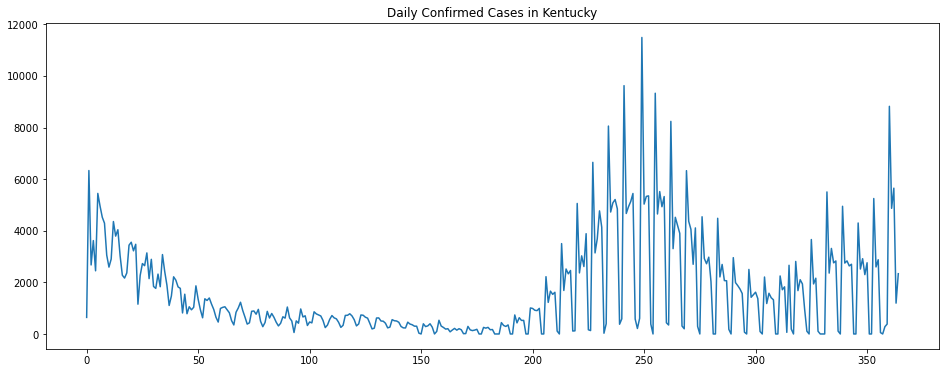

Kentucky -0.10788339657622617 0.039393219266970994
Kentucky -0.3943524234911199 4.967191199665061e-15
pearson from average Kentucky -0.15741562367493112 0.002781868216381145
spearman from average Kentucky -0.4811017523690094 3.3940148024134106e-22


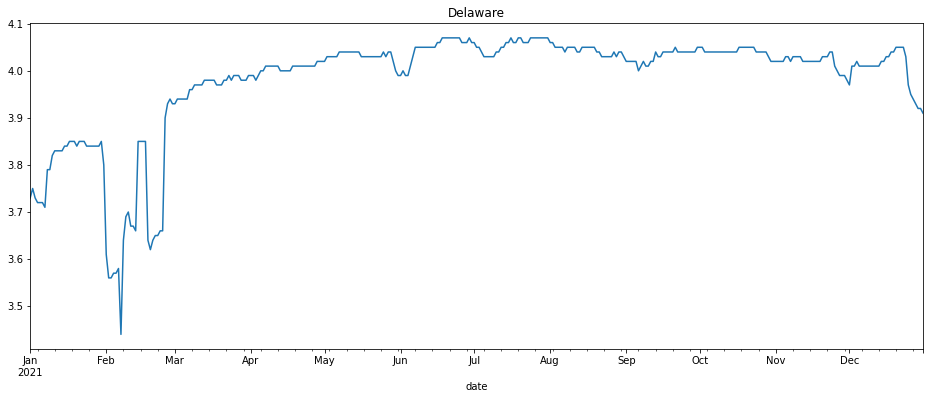

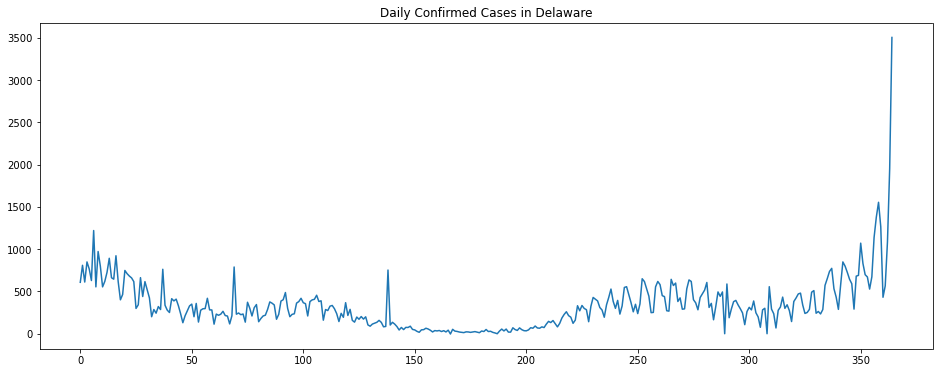

Delaware -0.26368282794385867 3.2027357636355056e-07
Delaware -0.44050099612142796 9.305055880086722e-19
pearson from average Delaware -0.3214352374896665 4.5083106082968547e-10
spearman from average Delaware -0.45069666373213285 2.3158138250763375e-19


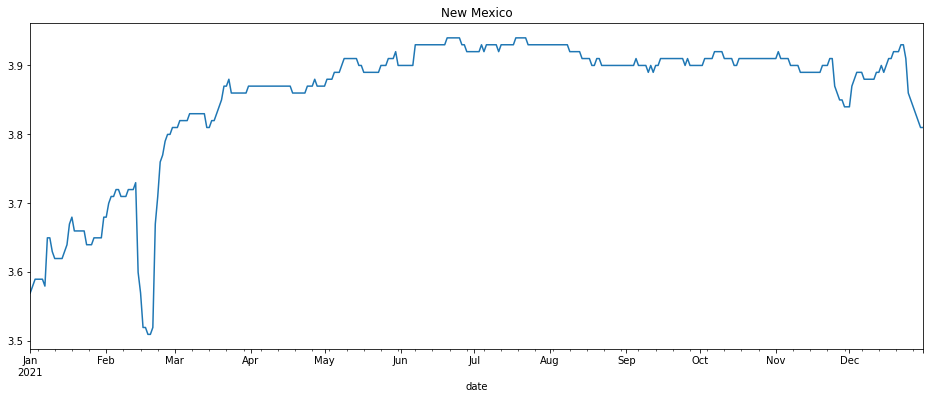

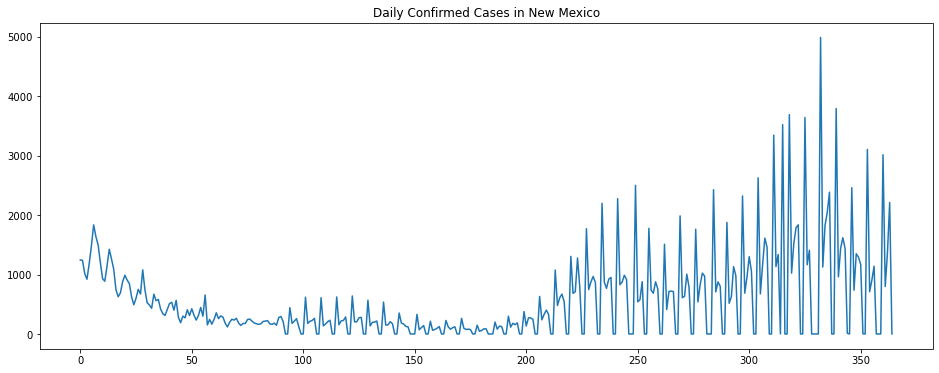

New Mexico -0.11641334793507946 0.02614764396976702
New Mexico -0.23324977995774052 6.693436351621028e-06
pearson from average New Mexico -0.1707253991345939 0.0011647433303226015
spearman from average New Mexico -0.26649325832121323 2.9803456108059e-07


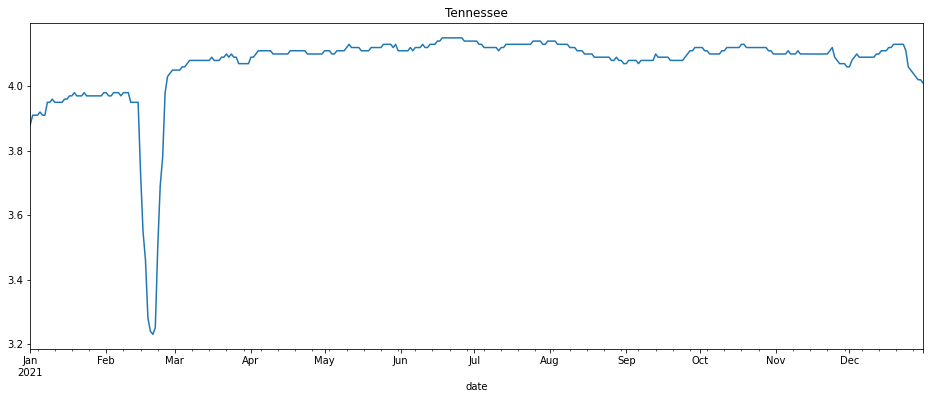

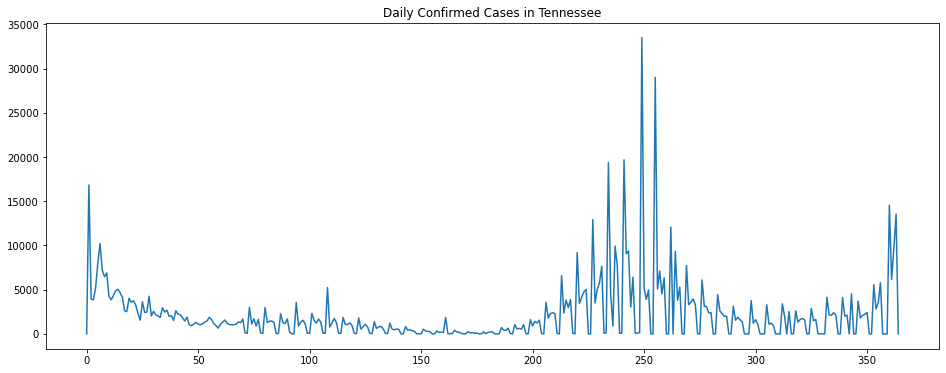

Tennessee -0.0790489470964238 0.1317062309891041
Tennessee -0.3346799040498716 5.297806478625673e-11
pearson from average Tennessee -0.13084615852979783 0.013093693520869051
spearman from average Tennessee -0.5255894062461096 6.897962969178889e-27


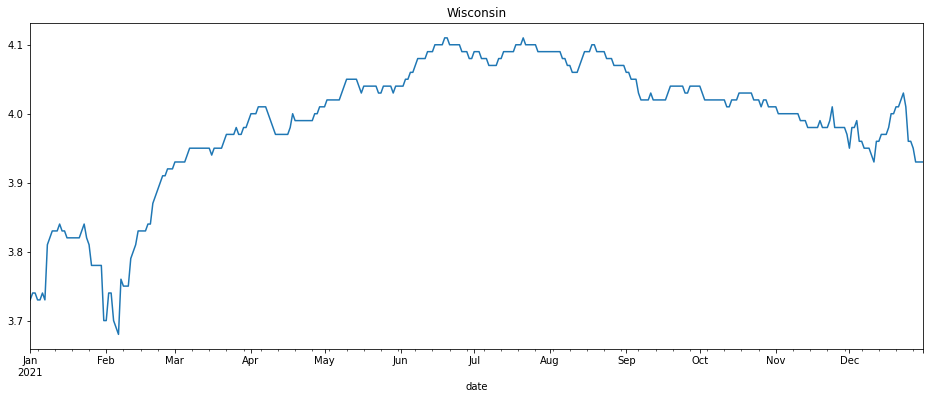

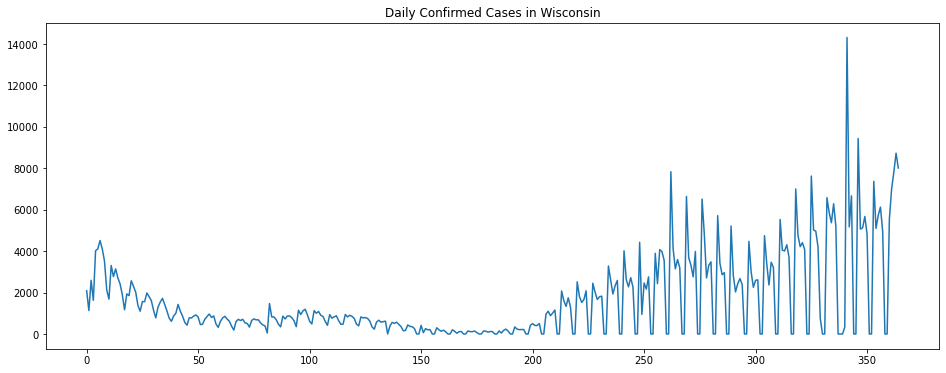

Wisconsin -0.15146228033931158 0.003725573411825764
Wisconsin -0.3312119959264746 8.573087564937356e-11
pearson from average Wisconsin -0.21639559856375495 3.550963753366719e-05
spearman from average Wisconsin -0.4032291942016066 1.8106540700207403e-15


In [11]:
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

pearson_list = list()
spearman_list = list()

## Cuebiq Contact Index data
path="./2021data"
CCI_df=pd.read_csv(path+'/2021_state_CMI.txt',dtype=object,sep = ",")
states=list(CCI_df.columns)[1:]
# print(CCI_df.head())
# print(states)

# Hospitalization Data
path="./2021data"
hospital_data = pd.read_csv(path+'/nyt-us-states.csv')
#print(hospital_data.head())


for state in states:
    df = CCI_df[["date",state]]
    df.set_index("date",inplace = True)
    distance_df = df.copy()
    distance_df.index = pd.to_datetime(distance_df.index) # convert to datetime
    distance_df.columns=['Distance']
    distance_df['Distance'] = pd.to_numeric(distance_df['Distance'])
    distance_df.sort_index(ascending=True) # select ranges of dates, sort the rows by date first
    #     start = distance_df.index.searchsorted(dt.datetime(2020, 5, 12))
    #     end = distance_df.index.searchsorted(dt.datetime(2020, 8, 15))
    #     distance_df = distance_df.iloc[start:end]
    distance_df['Distance'].plot(figsize = (16,6))
    plt.title(state)
    plt.show()

    df = hospital_data[hospital_data['state'] == state]
    #df['date'] = pd.to_datetime(df['date'])
    start_date = '2021-01-01'
    end_date = '2021-12-31'
    mask = (df['date'] >= start_date) & (df['date'] <= end_date)
    df = df.loc[mask]
    state_hospital_data = df.set_index('date')
    state_hospital_data.sort_index(ascending=True,inplace = True)    
    #     start = df.index.searchsorted(start_date)
    #     end = df.index.searchsorted(end_date)
    #     state_hospital_data = df.iloc[start:end]
    # state_hospital_data['cases'].plot(figsize = (16,6))
    # plt.show()
    y=state_hospital_data['cases']
    prev = hospital_data[(hospital_data['state'] == state)&(hospital_data['date'] == '2020-12-31')]["cases"].iloc[0]
    daily_hospital_data = [None] * len(y)
    for i in range(1,len(y)):
        daily_hospital_data[i] = y[i] - y[i-1]
    daily_hospital_data[0] = y[0]-prev
    #print(daily_hospital_data)
    pd.Series(daily_hospital_data).plot(figsize = (16,6))
    plt.title("Daily Confirmed Cases in "+state)
    plt.show()
    ## Correlation
    x = np.array(distance_df['Distance'])
    x = x.astype(float)
    y = np.array(state_hospital_data['cases'])
    r, p = scipy.stats.pearsonr(x, daily_hospital_data)
    print(state,r,p)
    r, p = scipy.stats.spearmanr(x, daily_hospital_data)
    print(state,r,p)
    daily_cases_moving_average = moving_average(daily_hospital_data,7)
    x_moving_average = moving_average(x,7)
    r, p = scipy.stats.pearsonr(x_moving_average, daily_cases_moving_average)
    print("pearson from average",state,r,p)
    pearson_list.append(r)
    r, p = scipy.stats.spearmanr(x_moving_average, daily_cases_moving_average)
    print("spearman from average",state,r,p)
    spearman_list.append(r)

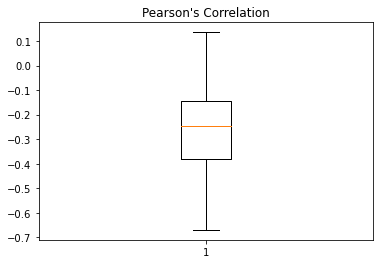

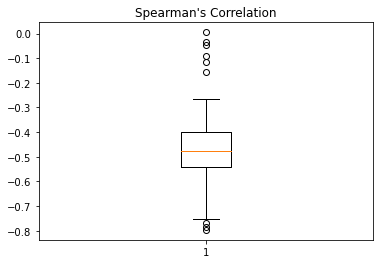

In [12]:
plt.boxplot(pearson_list)
plt.title("Pearson's Correlation")
plt.show()

plt.boxplot(spearman_list)
plt.title("Spearman's Correlation")
plt.show()

## Changepoint Detection For Wisconsin

In [13]:
def changepoint_ind(data,plot = False):
    data = np.array(data).reshape(len(data),1)
    prior_function = partial(const_prior, p=1/(len(data) + 1))
    Q, P, Pcp = offline_changepoint_detection(data, prior_function ,offline_ll.StudentT(),truncate=-40)
    psum = np.exp(Pcp).sum(0)
    if plot:
        fig, ax = plt.subplots(2, figsize=[18, 16], sharex=True)
        ax[0].plot(data[:])
        ax[1].plot(np.exp(Pcp).sum(0))
    changepoints = []
    candidate_ind = argrelextrema(psum, np.greater)
    for ind in candidate_ind[0]:
        if psum[ind]>0.1:
            changepoints.append(ind)
    return changepoints

## Find good changepoints for all states

In [14]:
path="./2021data/"
df=pd.read_csv(path+'2021_state_CMI.txt',dtype=object,sep = ",")
df.set_index("date",inplace = True)

In [15]:
df

Louisiana Michigan New Hampshire Oregon New York Colorado Wyoming  \
date                                                                           
2021-01-01      3.93     3.63          3.74   3.57     3.47     3.65    3.59   
2021-01-02      3.93     3.63          3.73   3.58      3.5     3.66    3.59   
2021-01-03      3.92     3.62          3.72   3.57     3.45     3.65    3.58   
2021-01-04      3.92     3.62          3.72   3.57     3.44     3.67    3.59   
2021-01-05      3.92     3.62          3.71   3.56     3.43     3.68    3.59   
...              ...      ...           ...    ...      ...      ...     ...   
2021-12-27      4.05     3.94          3.66   3.72     3.66     3.85    3.69   
2021-12-28      4.03     3.93          3.66   3.68     3.65     3.84    3.69   
2021-12-29      4.02     3.92          3.67   3.66     3.64     3.82    3.68   
2021-12-30      4.02     3.92          3.66   3.65     3.63     3.82    3.67   
2021-12-31      4.02     3.92          3.66   3.65     3.62     3.81    3.67   

           South Carolina Arkansas Nebraska  ... Virginia Rhode Island  \
date                                         ...                         
2021-01-01           3.91      3.9     3.61  ...     3.71         3.67   
2021-01-02           3.91     3.89     3.61  ...     3.72         3.68   
2021-01-03           3.91     3.89      3.6  ...     3.71         3.67   
2021-01-04           3.91     3.89     3.59  ...      3.7         3.66   
2021-01-05           3.91     3.89     3.77  ...      3.7         3.65   
...                   ...      ...      ...  ...      ...          ...   
2021-12-27           4.05     4.05     3.92  ...     3.92         3.84   
2021-12-28           4.04     4.04     3.91  ...     3.91         3.83   
2021-12-29           4.03     4.03     3.91  ...      3.9         3.83   
2021-12-30           4.02     4.03      3.9  ...      3.9         3.82   
2021-12-31           4.02     4.03      3.9  ...     3.89         3.82   

           North Dakota Minnesota Connecticut Kentucky Delaware New Mexico  \
date                                                                         
2021-01-01         3.67      3.66        3.68     3.85     3.73       3.57   
2021-01-02         3.67      3.66        3.69     3.87     3.75       3.58   
2021-01-03         3.68      3.69        3.66     3.87     3.73       3.59   
2021-01-04         3.67      3.68        3.66     3.87     3.72       3.59   
2021-01-05         3.68      3.69        3.65     3.87     3.72       3.59   
...                 ...       ...         ...      ...      ...        ...   
2021-12-27         3.69      3.94        3.81     4.04     3.94       3.84   
2021-12-28         3.67      3.92        3.81     4.02     3.93       3.83   
2021-12-29         3.66      3.91         3.8     4.02     3.92       3.82   
2021-12-30         3.66      3.91        3.79     4.01     3.92       3.81   
2021-12-31         3.66      3.91        3.79     4.01     3.91       3.81   

           Tennessee Wisconsin  
date                            
2021-01-01      3.88      3.73  
2021-01-02      3.91      3.74  
2021-01-03      3.91      3.74  
2021-01-04      3.91      3.73  
2021-01-05      3.92      3.73  
...              ...       ...  
2021-12-27      4.04      3.95  
2021-12-28      4.03      3.93  
2021-12-29      4.02      3.93  
2021-12-30      4.02      3.93  
2021-12-31      4.01      3.93  

[365 rows x 49 columns]

In [16]:
df = df.T.astype(float)

In [17]:
avg_CMI = df.mean(axis = 0)

[]

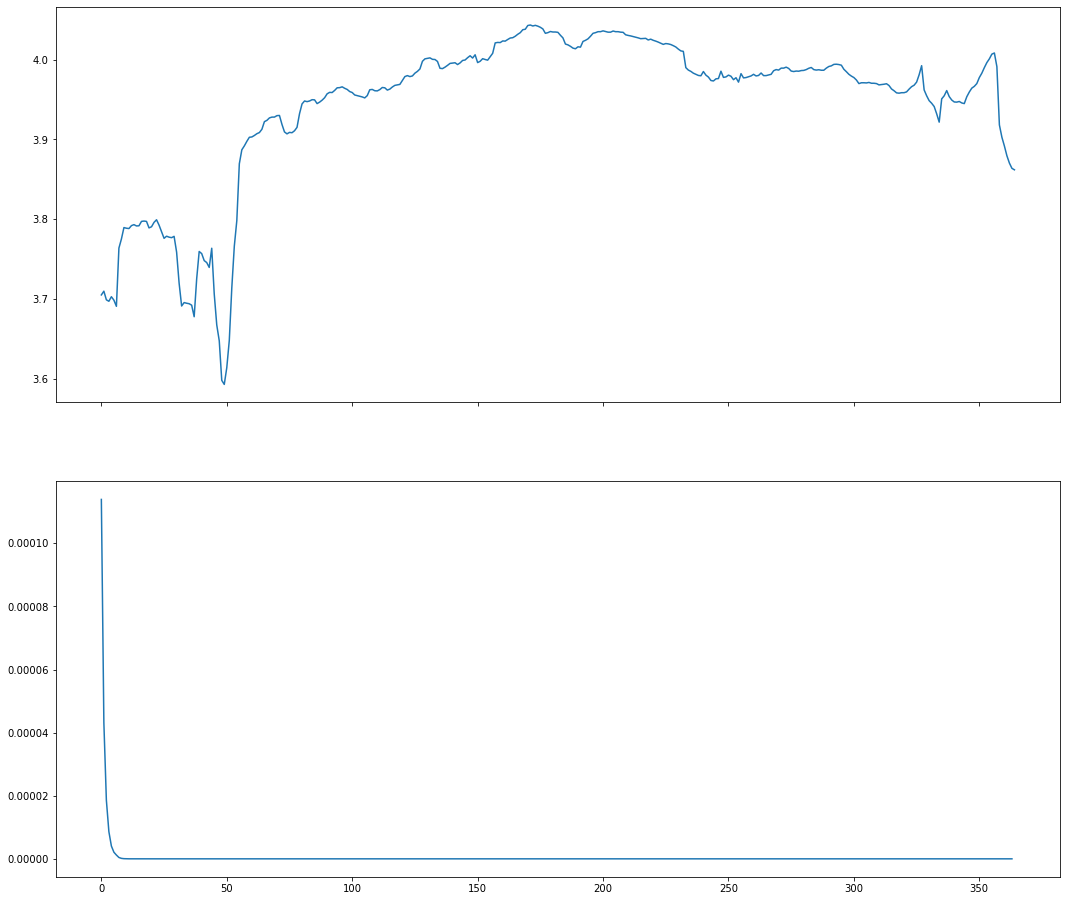

In [18]:
changepoint_ind(avg_CMI,True)